# Plot the APO model

In this notebook we import pre-run forward models for the APO components to plot the APO model and observations.

Figures created:
- $\delta$ APO contribution from each set of ocean fluxes;
- $\delta$ APO contribution from each species, and from the land and ocean;
- total $\delta$ APO model with observations;
- correlation between each $\delta$ APO model;
- correlation between the $\delta$ APO models and the observations.

In [1]:
import os, glob
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.obs import get_obs
from acrg.config.paths import Paths
from acrg.convert import concentration

plt.style.use('tableau-colorblind10')

# sys.path.append(os.environ['FUNCS'])
import apo_emiss_func, apo_filter, apo_plot_info, apo_funcs

/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [48]:
year = 2021
months = [8, 12] #[mm for mm in range(1, 13)] # [11,12] # 
sites = ['WAO', 'HFD', 'RGL'] #, ]#
ocean_sims = ['ECCO', 'Jena', 'NEMO']

# is poster==True figure will be formatted accordingly
poster = False #True

save = True #False

mf_o2 = 1 / 6.04

# include emissions from non-combustion ff sources?
include_non_comb = True # False]

# type of adjustment to apply to the baseline
baseline_adjust = 'pre_adjusted' #'visual'

##################################################
# get datetimes for all months to be included
months = [months] if type(months)==int else months
start_dates = {month: datetime(year, month, 1) for month in range(1,13)}
end_dates = {month: start_date + relativedelta(months=1, seconds=-1) for month, start_date in start_dates.items()}

# determine the number of rows which will be included in the figures
nrows = len(months) * len(sites)

# get the shortened names for the sites
sites = {site: code for site, code in apo_plot_info.sitecodes.items() if site in sites}

# create a string from the dates which will be used when saving figures
date_str = apo_funcs.make_date_string(year=year, months=months)

print(f'Date string for filename: {date_str}')

Date string for filename: 202108-202112


### Get the timeseries data

Import the pre-run forward models

In [49]:
ff_source = 'ff' if include_non_comb else 'ffcomb'
ts_data = apo_funcs.get_timeseries(sites=sites.keys(), year=year, sources=[ff_source, 'ocean', 'bc'])

for site, ts_site in ts_data.items():
    for spec in ['co2', 'o2']:
        if f'{spec}_ffcomb' in ts_site.data_vars:
            print(f'Renaming {spec}_ffcomb: {spec}_ff')
            ts_data[site] = ts_data[site].rename({f'{spec}_ffcomb': f'{spec}_ff'})

Finding timeseries for WAO
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2021.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2021.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2021.nc']

Dropping variables: 
['delta_o2_n2_bc', 'co2_ocean_ecco_mth', 'o2_ocean_ecco_mth', 'co2_ocean_nemo_mth', 'o2_ocean_nemo_mth']

Data variables: 
['co2_ff', 'o2_ff', 'co2_ocean_ecco', 'o2_ocean_ecco', 'co2_ocean_jena', 'o2_ocean_jena', 'co2_ocean_nemo', 'o2_ocean_nemo', 'n2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc', 'apo_adjusted_bc']
---------------------------

Finding timeseries for HFD
ff: ['/user/work/vf20487/Timeseries/o2_co2/HFD_ff_timeseries_2021.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/HFD_ocean_timeseries_2021.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/HFD_bc_timeseries_2021.nc']

Dropping variables: 
['delta_o2_n2_bc', 'co2_ocean_ecco_mth', 'o2_ocean_ecco_mth', 'co2_ocean_nemo_mth', 'o2_ocean_nemo_mth']

Data variables: 

### Split the timeseries into months

First split the timeseries data into months

Then adjust the baseline with the values determined from visual inspection, if required.

In [30]:
# if visually adjusting the baseline, do so here
if baseline_adjust=='visual':
        print('Adjusting baseline using visual inspection results')
        for site, ts_site in ts_data.items():
                for month, start in start_dates.items():
                        bc = {month: ts_site.apo_bc.sel(time=slice(start, end_dates[month])) - apo_plot_info.adjust[year][site][month]}
                        ts_data[site]['apo_adjusted_bc'] = xr.concat(bc.values(), dim='time')

species_labels = {source: f'{source.split("_")[0]} FF' if 'ff' in source else
                          f'{source.split("_")[0]} ocean, {[apo_plot_info.model_names[ss.lower()] for ss in ocean_sims if ss.lower() in source][0]}'
                          if 'ocean' in source else None
                  for source in ts_data[list(sites.keys())[0]].data_vars}

## Calculate APO

### Calculate APO contribution from each species

In [6]:
apo_species = {site: apo_emiss_func.apo_species_split(
                                                ocean_co2 = ts_site.co2_ocean_nemo,
                                                ocean_n2 = ts_site.n2_ocean_nemo,
                                                ocean_o2 = ts_site.o2_ocean_nemo,
                                                ff_co2 = ts_site.co2_ff,
                                                ff_o2 = ts_site.o2_ff,
                                                 mf_o2 = mf_o2)
            for site, ts_site in ts_data.items()}

for site, ts_site in ts_data.items():
        for spec in ['co2', 'o2']:
                apo_species[site] = {f'{spec}_ocean_nemo' if k==f'{spec}_ocean' else k:v for k,v in apo_species[site].items()}
                for sim in ['jena', 'ecco']:
                        ocean_flux = apo_emiss_func.apo_species_split(**{f'ocean_{spec}': ts_site[f'{spec}_ocean_{sim}']})
                        dv = [vv for vv in [f'{spec}_ocean', f'{spec}_ocean_{sim}'] if vv in ocean_flux.keys()][0]
                        apo_species[site][f'{spec}_ocean_{sim}'] = ocean_flux[dv]

### Calculate average contributions

Get the average contribution to APO from the ocean and fossil fuel O2 fluxes

In [7]:
contributions = {site: {month: {sim: np.median(ts_site[f'o2_ocean_{sim}'].sel(time=slice(start, end_dates[month])).values)
                                for sim in ['ecco', 'jena', 'nemo']}
                        for month, start in start_dates.items()}
                for site, ts_site in ts_data.items()}
print('Ocean contributions')
print_contribution = [[print(f'{site}, {apo_plot_info.month_names[month]}:    ECCO: {cont_month["ecco"]:.3f};    ' +
                             f'Jena: {cont_month["jena"]:.3f};    NEMO: {cont_month["nemo"]:.3f}')
                       for month, cont_month in cont_site.items()]
                      for site, cont_site in contributions.items()]

contributions_ff = {site: {month: np.mean(ts_site['o2_ff'].sel(time=slice(start, end_dates[month])).values)
                           for month, start in start_dates.items()}
                    for site, ts_site in ts_data.items()}
print('\nO2 ff contributions')
print_contribution = [[print(f'{site}, {apo_plot_info.month_names[month]}: {cont_month:.3f}')
                       for month, cont_month in cont_site.items()]
                      for site, cont_site in contributions_ff.items()]

Ocean contributions
WAO, Jan:    ECCO: -1.448;    Jena: -1.059;    NEMO: -0.936
WAO, Feb:    ECCO: -1.529;    Jena: -1.302;    NEMO: -1.182
WAO, Mar:    ECCO: -0.847;    Jena: -0.812;    NEMO: -0.560
WAO, Apr:    ECCO: 0.093;    Jena: 0.282;    NEMO: -0.005
WAO, May:    ECCO: 1.120;    Jena: 0.612;    NEMO: 1.041
WAO, Jun:    ECCO: 2.070;    Jena: 1.271;    NEMO: 2.797
WAO, Jul:    ECCO: 1.272;    Jena: 0.230;    NEMO: 2.205
WAO, Aug:    ECCO: 0.685;    Jena: 0.046;    NEMO: 1.137
WAO, Sep:    ECCO: 0.460;    Jena: -0.291;    NEMO: 0.269
WAO, Oct:    ECCO: -0.138;    Jena: -0.200;    NEMO: -0.423
WAO, Nov:    ECCO: -0.328;    Jena: -1.254;    NEMO: -0.655
WAO, Dec:    ECCO: -0.606;    Jena: -1.609;    NEMO: -0.857

O2 ff contributions
WAO, Jan: -4.289
WAO, Feb: -4.057
WAO, Mar: -3.286
WAO, Apr: -2.108
WAO, May: -2.319
WAO, Jun: -2.100
WAO, Jul: -2.330
WAO, Aug: -2.535
WAO, Sep: -2.767
WAO, Oct: -3.617
WAO, Nov: -3.587
WAO, Dec: -3.743


### Calculate ff & ocean APO contributions

First calculate the ocean and ff components and define APO labels

In [8]:
apo_split = {site: {ocean_sim.split("_")[-1]: apo_site[f'co2_ocean_{sim.lower()}'] + apo_o2 + apo_site['n2_ocean']
                    for ocean_sim, apo_o2 in apo_site.items() if ocean_sim[:8]=='o2_ocean'}
             for site, apo_site in apo_species.items()}
for site, apo_site in apo_species.items():
    apo_split[site]['ff'] = apo_site['co2_ff']

apo_labels = {source: 'FF' if source=='ff' else f'ocean, {[apo_plot_info.model_names[ss.lower()] for ss in ocean_sims if ss.lower()==source][0]}'
              for source in apo_split[list(sites.keys())[0]].keys()}
apo_labels

{'nemo': 'ocean, NE', 'jena': 'ocean, JC', 'ecco': 'ocean, ED', 'ff': 'FF'}

### Calculate the total APO

Here we calculate the toal APO timeseries

In [50]:
# get the baseline
bc = {site: ts_site.apo_bc if baseline_adjust!='pre_adjusted' or 'apo_adjusted_bc' not in ts_site.data_vars else
            ts_site.apo_adjusted_bc
      for site, ts_site in ts_data.items()}

# calculate the APO model for each ocean flux
apo_model = {site: {sim: apo_emiss_func.apo(
                                   ocean_co2 = ts_site[f'co2_ocean_{sim.lower()}'],
                                   ocean_n2 = ts_site.n2_ocean_nemo,
                                   ocean_o2 = ts_site[f'o2_ocean_{sim.lower()}'],
                                   ff_co2 = ts_site.co2_ff,
                                   ff_o2 = ts_site.o2_ff,
                                   mf_o2 = mf_o2) + bc[site]
                            for sim in ocean_sims}
             for site, ts_site in ts_data.items()}

# calculate the APO model with no ocean flux
apo_model_no_ocean = {site: apo_emiss_func.apo(
                                   ocean_co2 = xr.zeros_like(ts_site.o2_ocean_nemo),
                                   ocean_n2 = xr.zeros_like(ts_site.o2_ocean_nemo),
                                   ocean_o2 = xr.zeros_like(ts_site.o2_ocean_nemo),
                                   ff_co2 = ts_site.co2_ff,
                                   ff_o2 = ts_site.o2_ff,
                                   mf_o2 = mf_o2) + bc[site]
                      for site, ts_site in ts_data.items()}

# combine the above dictionaries
apo_model = {site: {sim: apo_model_no_ocean[site] if sim=='no ocean' else apo_site[sim]
                    for sim in list(apo_site.keys())+['no ocean']}
             for site, apo_site in apo_model.items()}

### Import the observations

In [71]:
apo_obs_year = get_obs(list(sites.keys()), 'APO', f'{year}-01-01', f'{year+1}-01-01', keep_missing=True)
if 'HFD' in sites.keys() and year>=2021:
    if len(apo_obs_year['HFD'])==0:
        fname_hfd = glob.glob(os.path.join('/group', 'chemistry', 'acrg', 'obs', 'HFD', f'UEA-Oxzilla_HFD_2021*APO*.nc'))[0]
        apo_obs_year['HFD'] = name.open_ds(fname_hfd)
        apo_obs_year['HFD']['mf'] = apo_obs_year['HFD'].apo
        apo_obs_year['HFD'] = [apo_obs_year['HFD']]

apo_obs_year = {site: apo_site[0].mf if len(apo_site)>0 else [] for site, apo_site in apo_obs_year.items()}

apo_obs = {site: {month: apo_site.sel(time=slice(start, end_dates[month])) if len(apo_site)>0 else []
                  for month, start in start_dates.items()}
           for site, apo_site in apo_obs_year.items()}
           

Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20210101_APO-20230213.nc
... slicing from 2021-01-01 00:00:00 to 2021-12-31 23:59:59.999999999
Getting APO data for HFD...
Getting APO data for RGL...


### Import REBS obs baseline

Import the baseline fit to the observations by REBS so that we can plot it

In [53]:
if year==2015:
    obs_baseline_file = glob.glob(os.path.join('/user', 'work', 'vf20487', 'Data', f'WAO*{year}*baseline*txt'))[0]
    print(f'REBS obs baseline file: {obs_baseline_file}')

    # read in the data
    obs_baseline_yr = pd.read_csv(obs_baseline_file, delimiter='\t')
    # convert the dates to datetimes
    obs_baseline_yr['time'] = pd.to_datetime(obs_baseline_yr['date'], format='%d/%m/%Y %H:%M')
    obs_baseline_yr = obs_baseline_yr.rename(columns={'Stiff baseline - small gaps interpolated': 'baseline'})
    obs_baseline_all = obs_baseline_yr.set_index('time').to_xarray()
    obs_baseline_yr = obs_baseline_all.baseline

## Plot APO

### Plot the components

First plot just the 3 ocean O2 fluxes

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_timeseries_speciesAPO_WAO_201508-201512.png


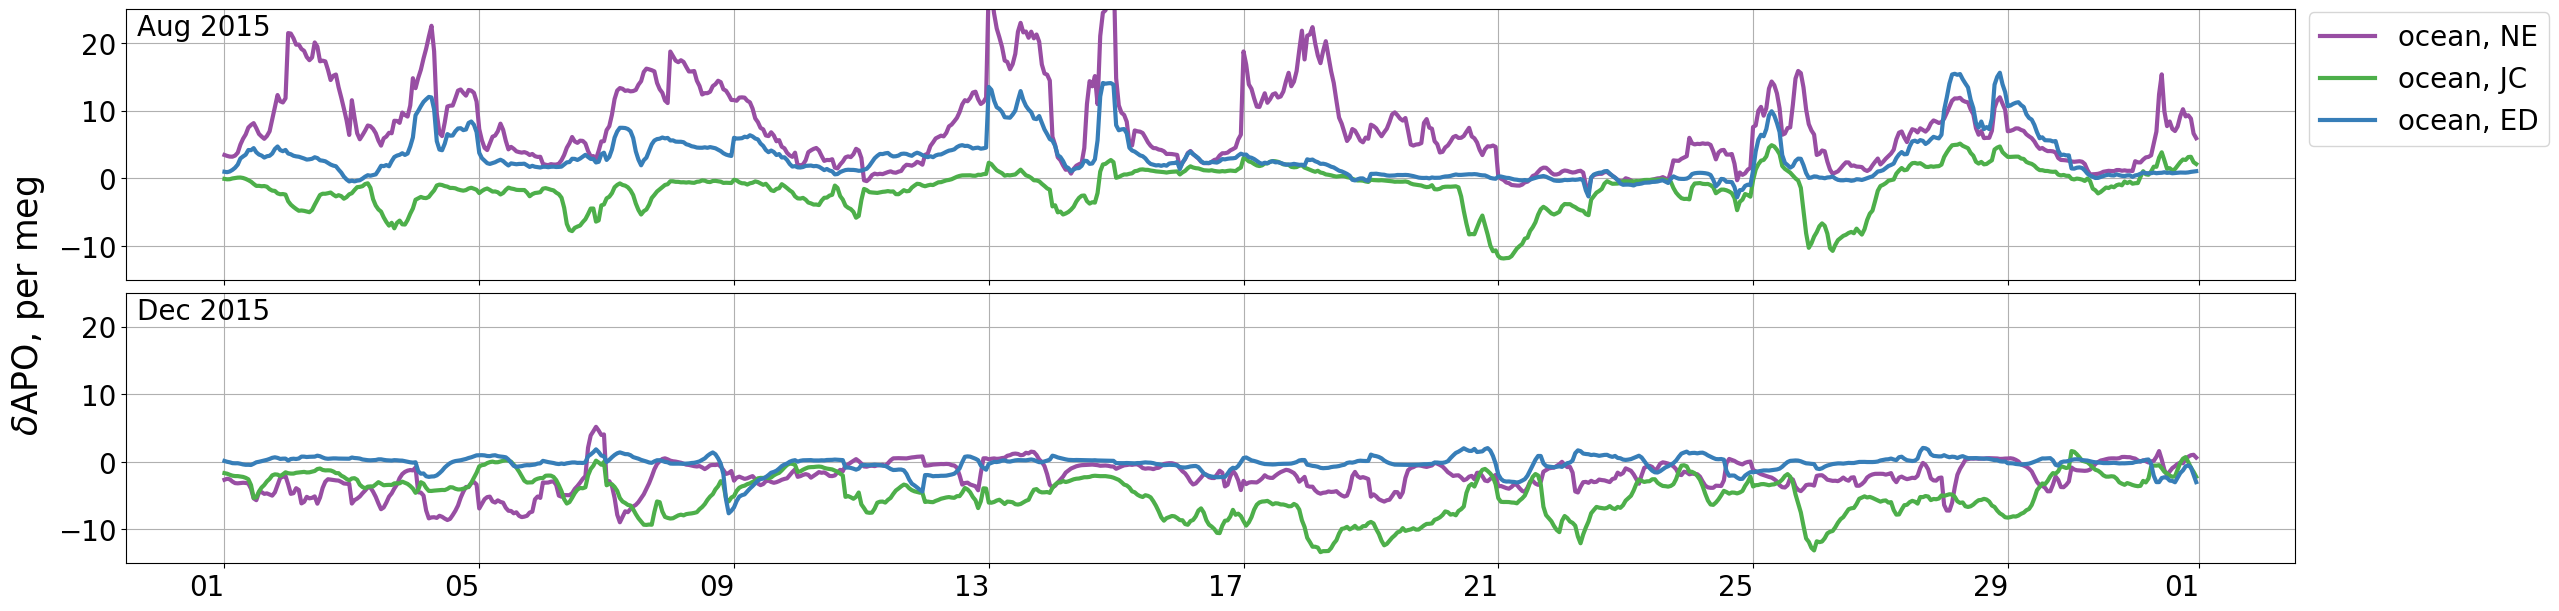

In [13]:
rowsize = 6 if len(sites)==1 and len(months)==1 else 3
fig, axes = plt.subplots(nrows=len(sites)*len(months), ncols=1, 
                         figsize=(25, rowsize*len(sites)*len(months)), constrained_layout=True)
axes = np.array([axes]) if len(sites)==1 and len(months)==1 else axes

# add a line for each ocean model
lines = {site: {month: [apo_site[var.lower()].sel(time=slice(start_dates[month], end_dates[month])).plot(ax=axes[ss+len(sites)*mm],
                                                                                                         color=apo_plot_info.colors[var],
                                                                                                         label=f'{label}',
                                                                                                         lw=3)
                        for var, label in apo_labels.items() if 'ff' not in var]
                for mm, month in enumerate(months)}
         for ss, (site, apo_site) in enumerate(apo_split.items())}

legend = axes[0].legend(bbox_to_anchor=(1,1.04), fontsize=20)

# format the axis labels
xlabel = axes[0].set_xlabel(f'Day in {apo_plot_info.month_names[month]}, {year}', fontsize=25) \
         if len(sites)==1 and len(months)==1 else [ax.set_xlabel('') for ax in axes]
ylabel = [ax.set_ylabel('') for ax in axes]
ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)

# make the y limits the same for each axis
ylim = [ax.set_ylim(-15, 25)for ax in axes]

# format the tick labels
myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=len(sites)*len(months)-1]

# add the month name
text = {month: axes[len(sites)*mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[len(sites)*mm].transAxes, va='top', fontsize=20)
        for mm, month in enumerate(months)}
grid = [ax.grid() for ax in axes]

if poster:
        text = axes[-1].text(1.01, 0.7, r'Fig. 3:', transform=axes[-1].transAxes, va='top', fontsize=20)
        text = axes[-1].text(1.01, 0.55, r'Modelled contribution' + '\nfrom the ocean and fossil' +
                             '\nfuel components to $\delta$APO' + '\nat Weybourne during' + f'\nAug and Dec {year}.',
                             transform=axes[-1].transAxes, va='top', fontsize=20)

# add letters to label each axis panel
if len(sites)>1:
   sites_text = list(sites.values())*len(months)
   [ax.text(0.005, 0.015, sites_text[aa], va='bottom', transform=ax.transAxes, fontsize=20)
    for aa, ax in enumerate(axes)]

if save:
        filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                                f'APO_timeseries_speciesAPO_{"-".join(sites)}_{date_str}.png')
        print(f'Saving to {filename}')
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

Now plot all of the APO components

1. each species in ppm,
2. the ocean and land in per meg.

In [12]:
save = False

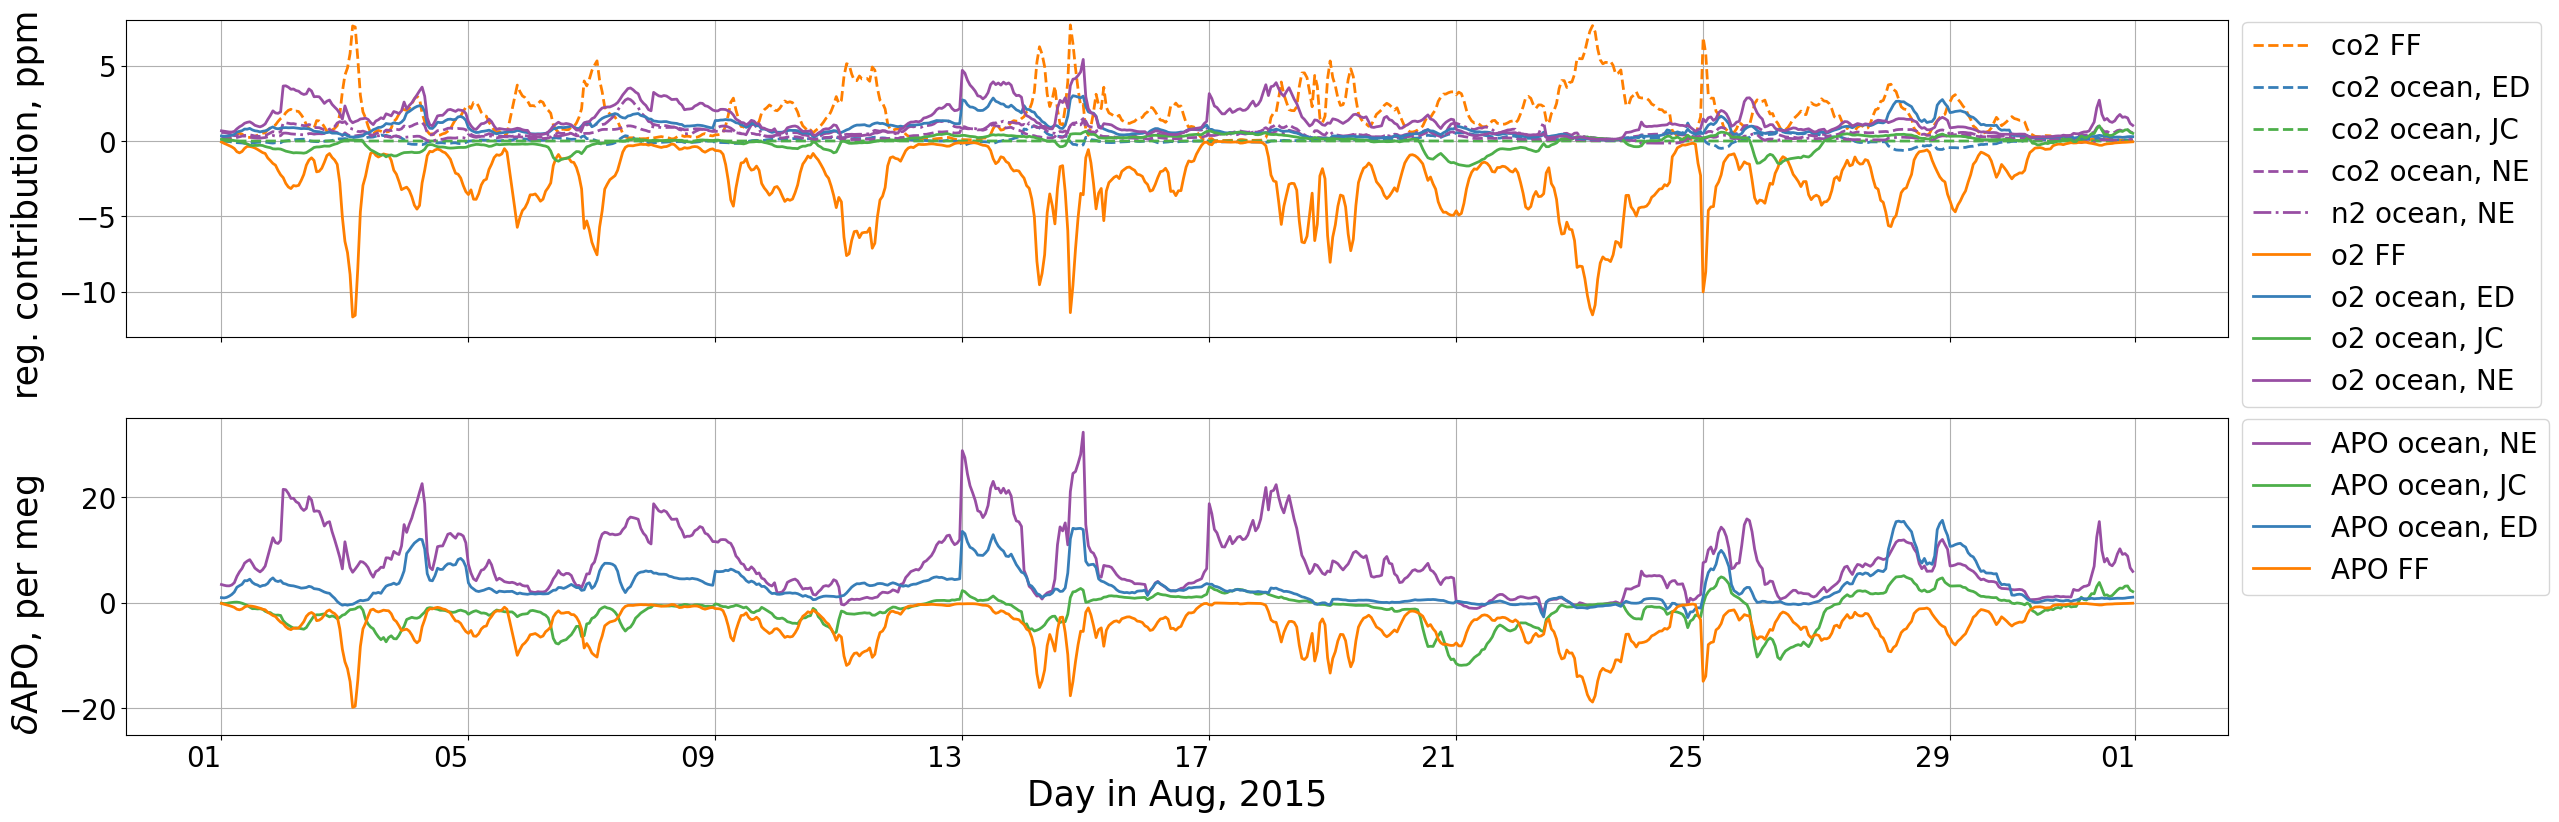

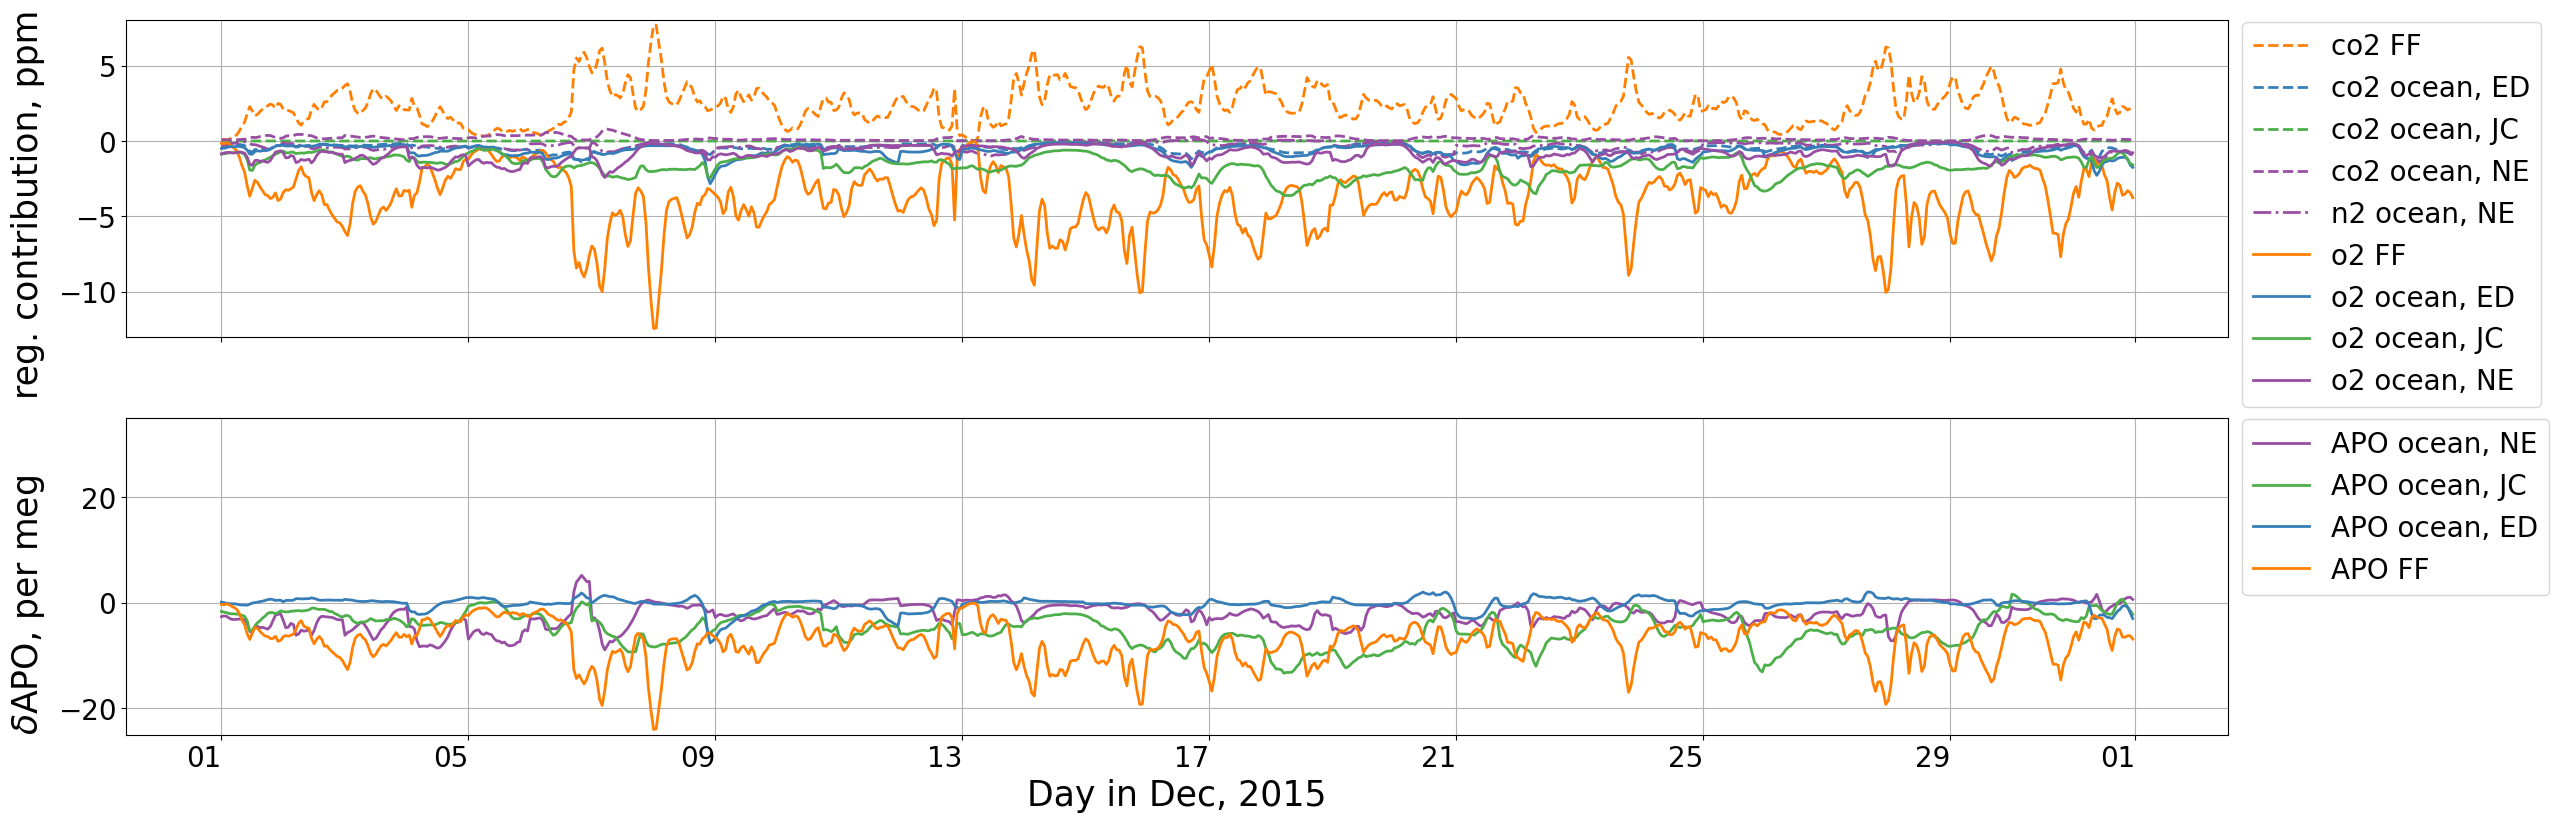

In [13]:
for mm, month in enumerate(months):
   fig, axes = plt.subplots(nrows=2*len(sites), ncols=1, figsize=(25, 4*2*len(sites)), constrained_layout=True)

   # plot the contribution in ppm
   lines = {site: [ts_site[var].sel(time=slice(start_dates[month], end_dates[month])).plot(ax=axes[ss],
                                                                                           label=species_labels[var],
                                                                                           ls=apo_plot_info.ls[var.split('_')[0]],
                                                                                           color=apo_plot_info.colors_sources[var.split('2_')[1].lower()],
                                                                                           lw=2)
                   for vv, var in enumerate(sorted(ts_site.data_vars)) if all([ss not in var for ss in ['diff', 'unc',  'bc']])]
            for ss, (site, ts_site) in enumerate(ts_data.items())}

   # plot the APO land & ocean contributions in per meg
   lines = {site: [apo_site[var.lower()].sel(time=slice(start_dates[month], end_dates[month])).plot(ax=axes[len(sites)+ss],
                                                                                                    color=apo_plot_info.colors[var],
                                                                                                    label=f'APO {label}',
                                                                                                    lw=2)
                   for var, label in apo_labels.items()]
            for ss, (site, apo_site) in enumerate(apo_split.items())}

   # format the tick labels
   myFmt = mdates.DateFormatter('%d')
   [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
   ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]

   # format the axis labels
   xlabel = [ax.set_xlabel('') for ax in axes]
   if len(sites)==1:
      xlabel = axes[1].set_xlabel(f'Day in {apo_plot_info.month_names[month]}, {year}', fontsize=25)
      ticks = axes[0].xaxis.set_ticklabels([])
   else:
      xlabel = [axes[ii*len(sites)+2].set_xlabel(f'Day in {apo_plot_info.month_names[month]}, {year}', fontsize=25)
               for ii in range(2)]
      ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii not in [jj*len(sites)+2 for jj in range(2)]]
   ylabel = [ax.set_ylabel('') for ax in axes]
   ylabel = fig.text(-0.01, 0.765, 'reg. contribution, ppm', va='center', ha='center', rotation='vertical', fontsize=25)
   ylabel = fig.text(-0.01, 0.265, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)

   # make the y limits the same for each set of axes
   ylim = [axes[ii].set_ylim(-13, 8) for ii in range(len(sites))]
   ylim = [axes[ii].set_ylim(-25, 35) for ii in range(len(sites), len(sites)*2)]
   # add a legend outside of the axis
   legend = [axes[ii].legend(bbox_to_anchor=(1, 1.04), loc='upper left', fontsize=20) for ii in [0, len(sites)]]

   grid = [ax.grid() for ax in axes]

   # add letters to label each axis panel
   if len(sites)>1:
      sites_text = list(sites.values())*2
      letters = [chr(97 + int(aa)+len(sites_text*mm) - 26*int(np.ceil((aa+1+len(sites_text*mm))/26.)-1))*int(np.ceil((aa+1+len(sites_text*mm))/26.))
                 for aa in range(6)]
      [ax.text(0.005, 0.015, f'{letters[aa]}) {sites_text[aa]}', va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]
   
   if save:
      filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                              f'APO_timeseries_species_{"-".join(sites)}_{year}{str(month).zfill(2)}.png')
      print(f'Saving to {filename}')
      fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

### Plot the total APO model and observations

Now we plot the total APO timeseries

We use a separate axis for each month and site, which will contain:

- the total APO model for each ocean flux,
- the APO baseline, estimated from Jena Carboscope boundary conditions,
- the APO observations, where possible.

In [61]:
supplement = True #False #
save = True #False #

months = [month for month in range(1,5)]
print(months)

nrows = len(months) * len(sites)
print(nrows)

[1, 2, 3, 4]
12


In [73]:
apo_obs.keys()

dict_keys(['WAO', 'HFD', 'RGL'])

KeyError: 0

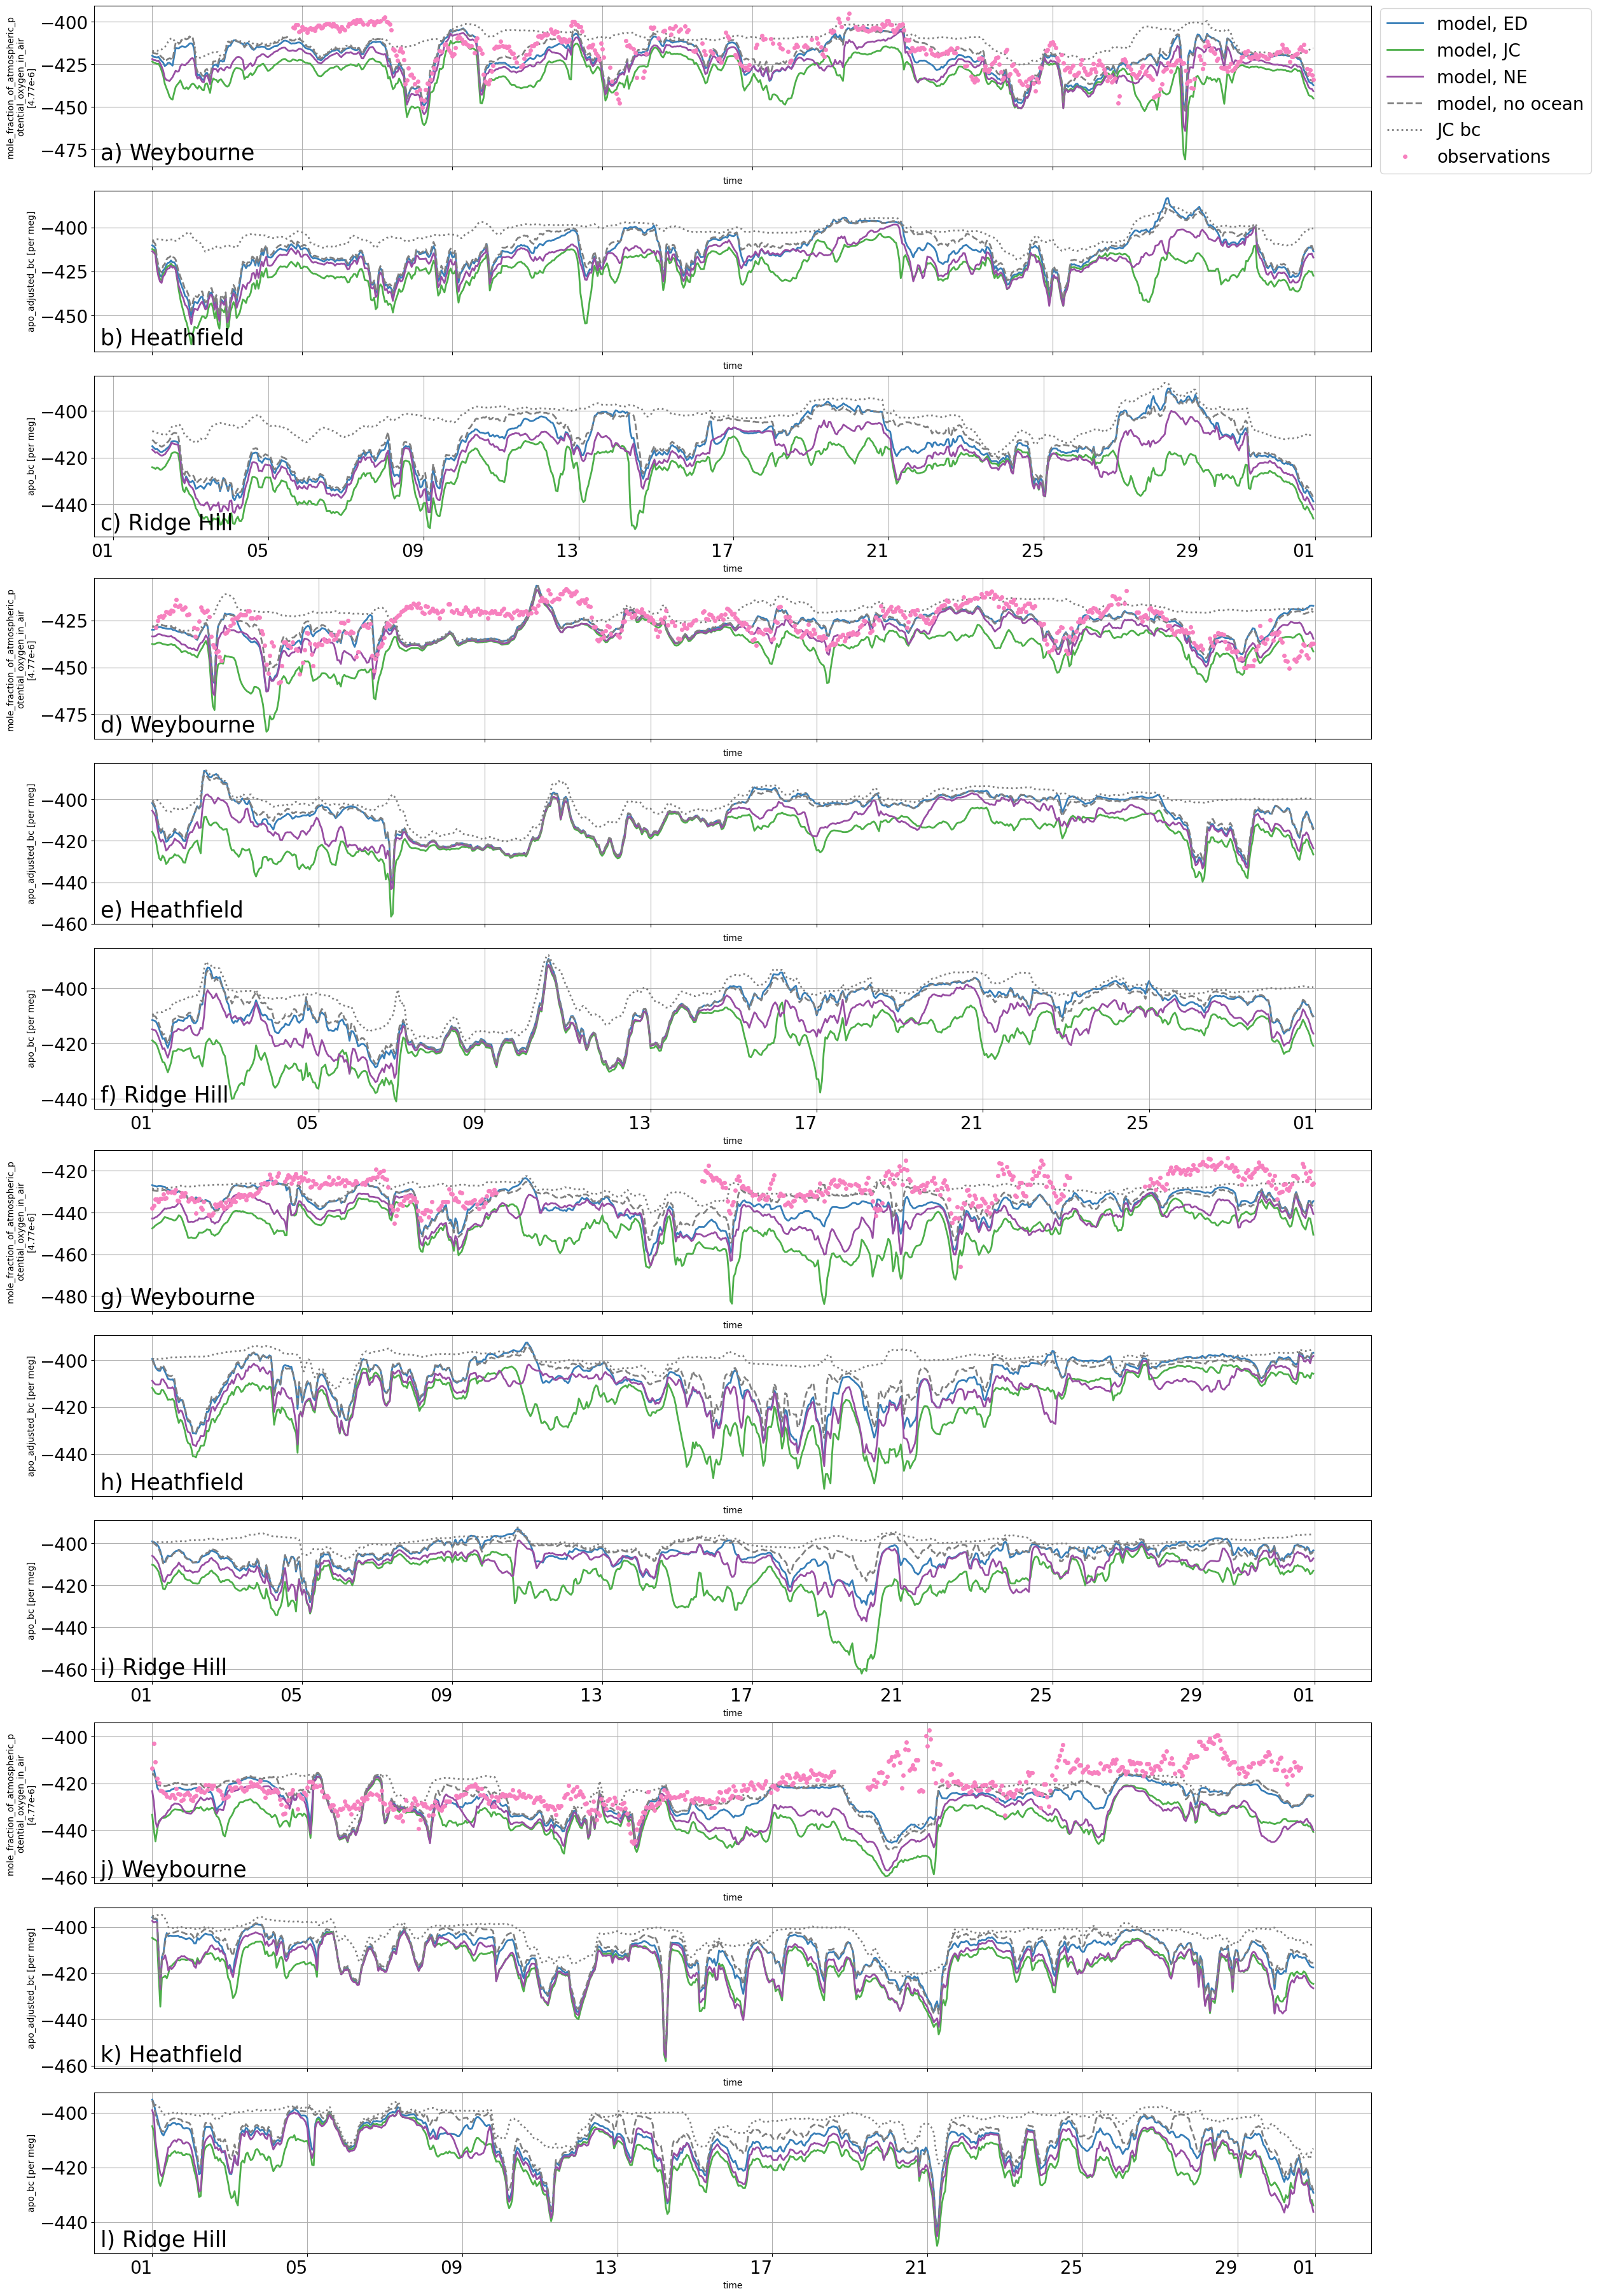

In [75]:
row_size = 3 if len(months) in [3, 4, 6] or poster else 6 if len(months)==2 and len(sites)==1 else 4 if any([len(var)>1 for var in [months, sites]]) else 8
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(25, row_size*nrows), constrained_layout=True)
axes = axes if type(axes)==np.ndarray else [axes]

ls = {sim: '--' if sim=='no ocean' else '-' for sim in apo_model[list(sites.keys())[0]]}
# plot a line for each model
model_plots = {site: {month: {sim: apo_sim.sel(time=slice(start_dates[month], end_dates[month])).plot(ax=axes[ss+mm*len(sites)],
                                                                                                      color=apo_plot_info.colors[sim.lower()],
                                                                                                      lw=2,
                                                                                                      ls=ls[sim],
                                                                                                      label=f'model, {apo_plot_info.model_names[sim.lower()]}')
                              for sim, apo_sim in apo_site.items()}
                      for mm, month in enumerate(months)}
               for ss, (site, apo_site) in enumerate(apo_model.items())}
# plot a line for the JC baseline
bkg_plots = {site: {month: bc_site.sel(time=slice(start_dates[month], end_dates[month])).plot(ax=axes[ss+mm*len(sites)],
                                                                                              color='grey',
                                                                                              lw=2,
                                                                                              ls=':',
                                                                                              label=f'JC bc')
                    for mm, month in enumerate(months)}
             for ss, (site, bc_site) in enumerate(bc.items())}
# plot a line for the REBS baseline (from the obs)
if year==2015:
       rebs_plots = {month: obs_baseline_yr.sel(time=slice(start_dates[month], end_dates[month])).plot(ax=axes[mm*len(sites)],
                                                                                                       color='purple',
                                                                                                       lw=2,
                                                                                                       ls=':',
                                                                                                       label=f'REBS baseline')
              for mm, month in enumerate(months) if 'WAO' in sites}
# plot the observations as points
obs_plots = {site: [apo_site[month].plot(ax=axes[ss+mm*len(sites)],
                                         color='#f781bf',
                                         label='observations',
                                         marker='o',
                                         ls='none',
                                         markersize=4)
                    for mm, month in enumerate(months) if len(apo_site[month])>0]
             for ss, (site, apo_site) in enumerate(apo_obs.items())}

# format the tick labels
if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

# add letters to label each axis panel
if len(sites)>1:
       letter_start = len(sites)*(months[0]-1) if supplement else 0
       letters = [chr(97 + int(letter_start+ll)) if letter_start+ll<26 else
                  chr(97 + int(letter_start+ll-26))*2
                  for ll in range(len(months)*len(sites))]
       [axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes)) if (i+1)%len(sites)!=0]]
       sites_text = list(sites.values())*len(months)
       [ax.text(0.005, 0.015, f'{letters[aa]}) {sites_text[aa]}', va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

# add a legend outside of the axis
legend = axes[0].legend(fontsize=20, bbox_to_anchor=(1., 1.04), loc='upper left')
grid = [ax.grid() for ax in axes]
# set the y limits to be the same for each axis
ylimits = {2015: [-370, -280] if months==[8, 12] else [-420, -205],
           2021: [-460, -340]}
ylims = [ax.set_ylim(ylimits[year][0], ylimits[year][1]) for ax in axes]

# format the axis labels
xlabels = [ax.set_xlabel('') for ax in axes]
xlabels = [axes[m*len(sites)+(len(sites)-1)].set_xlabel(f'Day in {apo_plot_info.month_names[month]}', fontsize=25)
           for m, month in enumerate(months)]
if len(axes)>1:
       ylabels = [ax.set_ylabel('') for ax in axes]
       ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
else: ylabels = axes[0].set_ylabel(r'$\delta$APO, per meg', fontsize=30)

if poster:
       text = axes[-1].text(1.01, 0.7, 'Fig. 2:',
              transform=axes[-1].transAxes, va='top', fontsize=20) 
       text = axes[-1].text(1.01, 0.55, r'Modelled and' + '\nobserved $\delta$APO at' + '\nWeybourne during' + '\nAugust and December' + f'\n{year}.',
              transform=axes[-1].transAxes, va='top', fontsize=20)

if save:
       date_str = apo_funcs.make_date_string(year=year, months=months)
       filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'APO_timeseries_{"-".join(sites)}_{date_str}.png')
       print(f'Saving to {filename}')
       fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

### Plot the models vs obs as a scatter

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_modelvsobs_WAO_2015.png


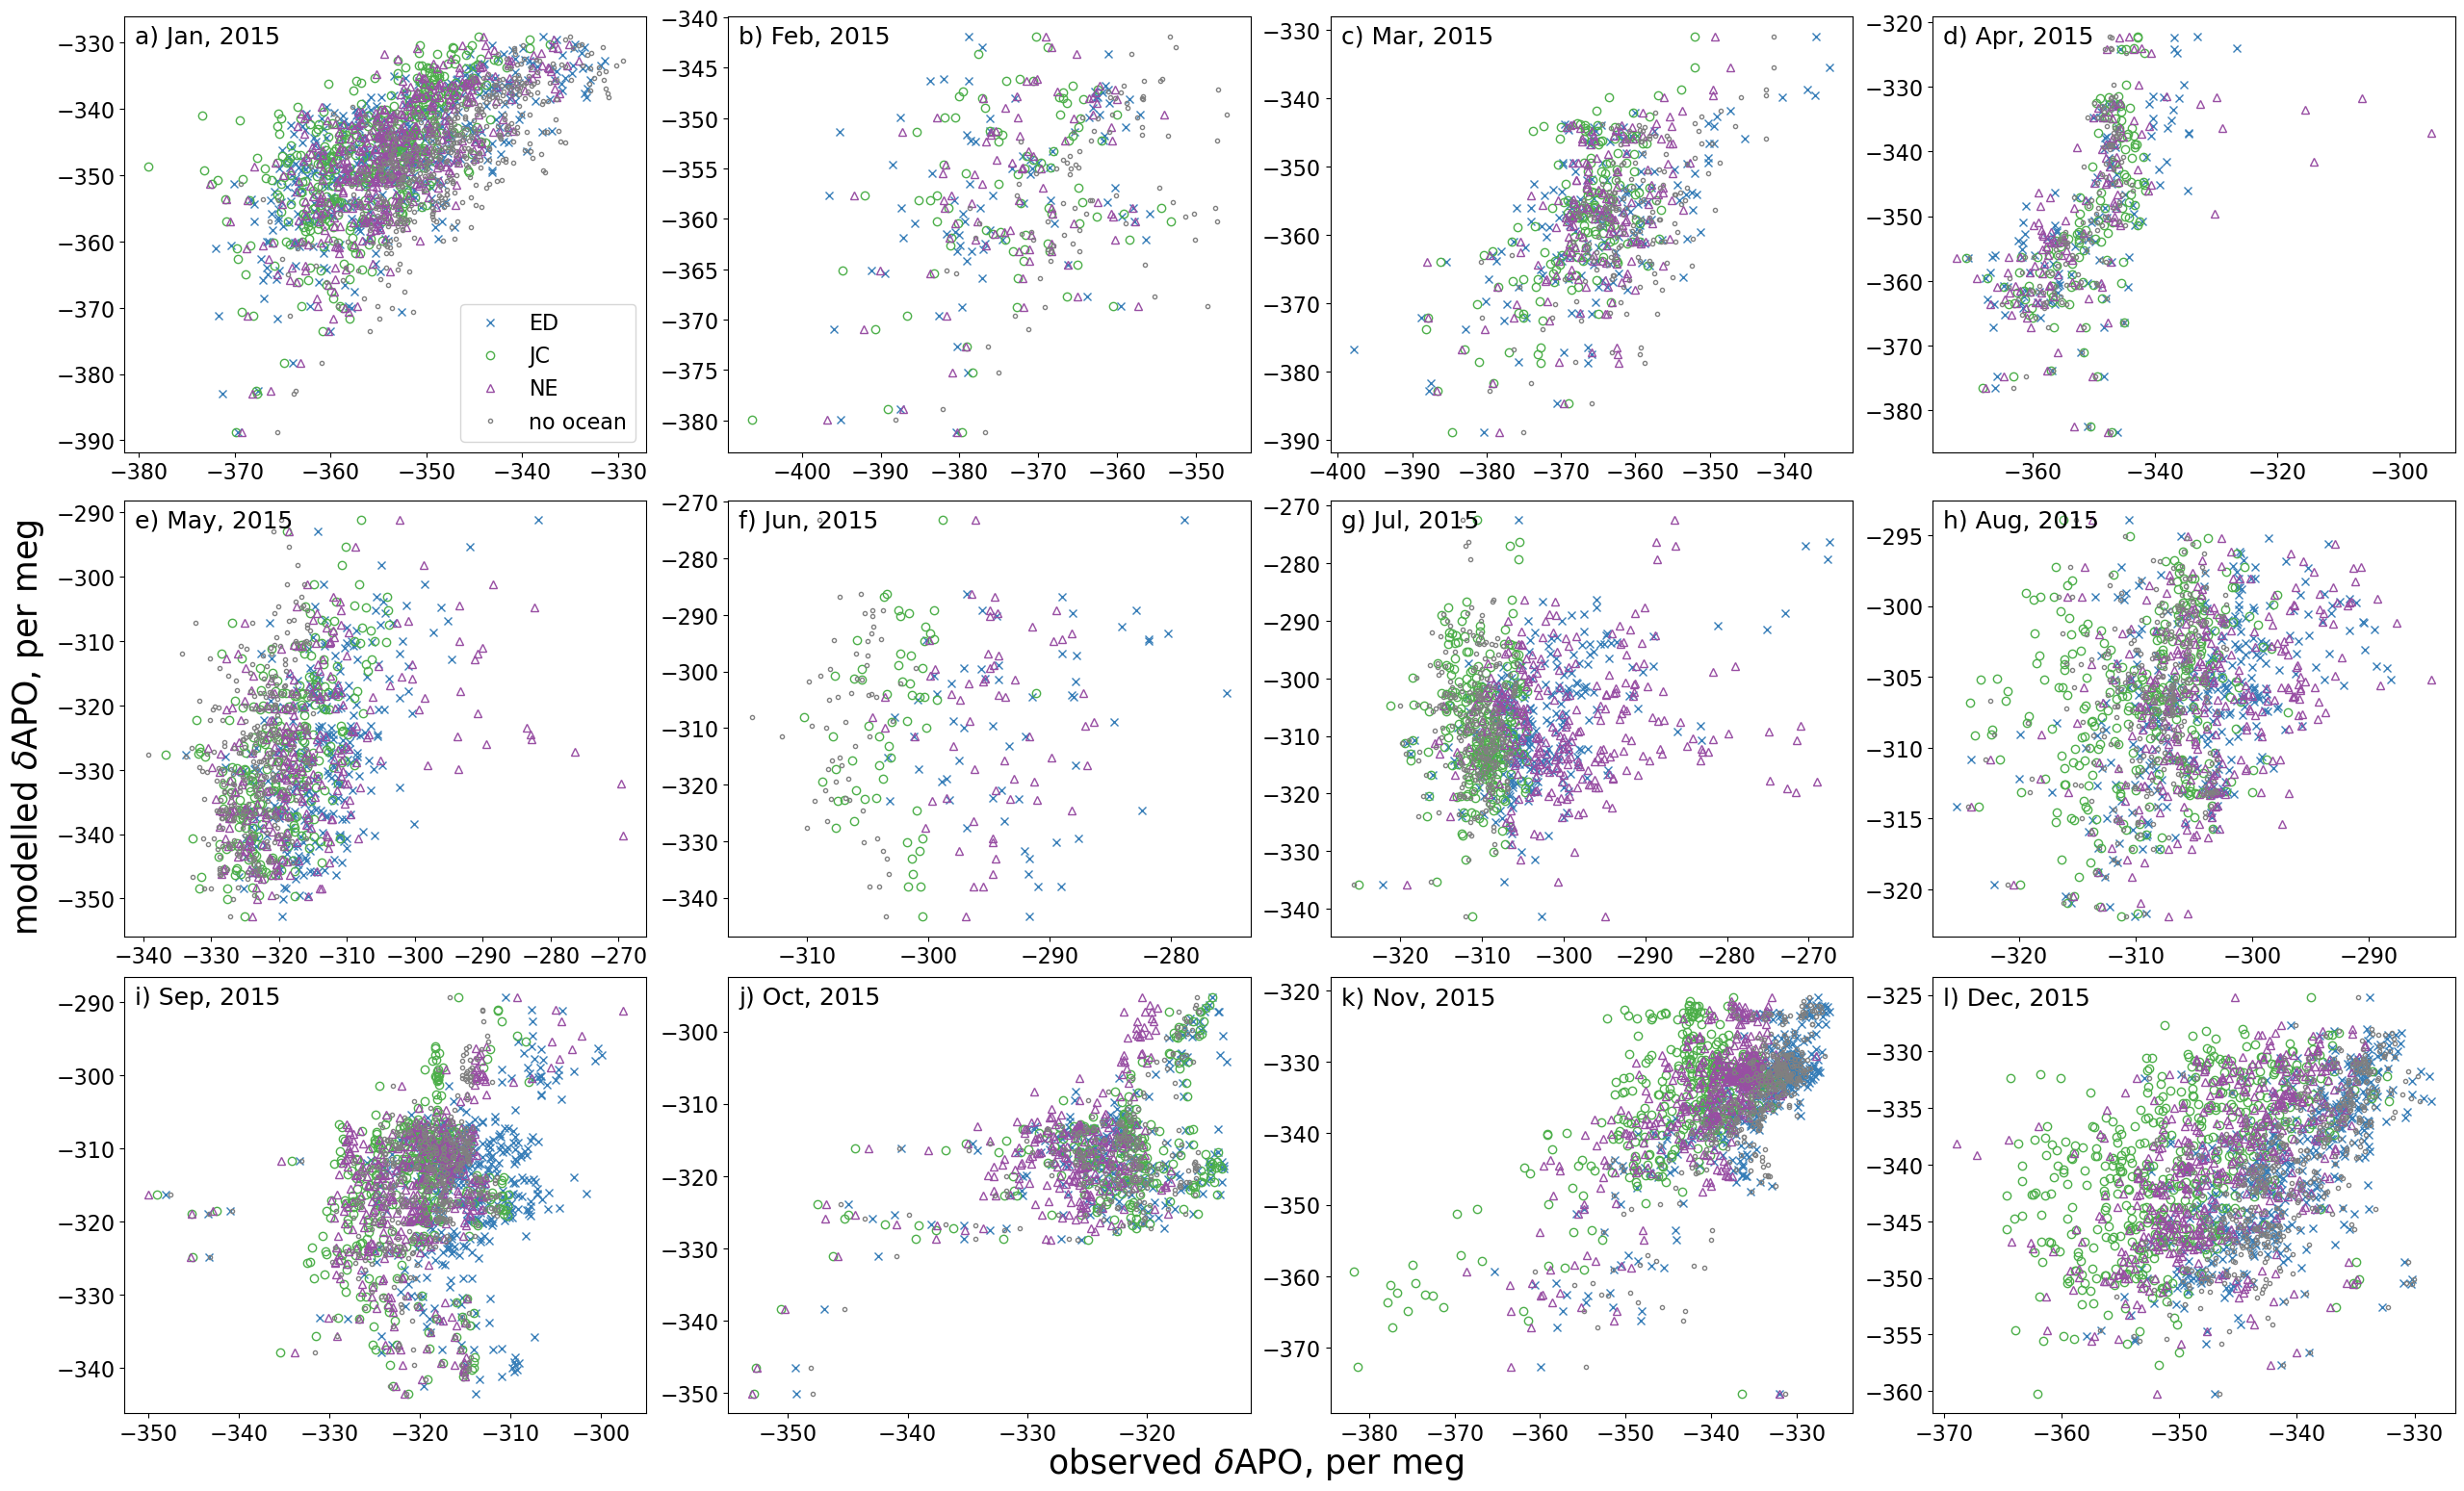

In [25]:
markers = {'ECCO': 'x', 'Jena': 'o', 'NEMO': '^', 'no ocean': '.'}
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, 15), constrained_layout=True)

for mm, month in enumerate(range(1,13)):
    model_obs_plot = [axes.flat[mm].plot(apo_sim.values.sel(time=slice(start_dates[month], end_dates[month])),
                                         apo_obs_year[list(sites.keys())[0]].sel(time=slice(start_dates[month], end_dates[month])).values,
                                         markers[sim], markerfacecolor="none", markeredgecolor=apo_plot_info.colors[sim.lower()],
                                         label=apo_plot_info.model_names[sim.lower()])
                      for sim, apo_sim in apo_model['WAO'].items()]
    month_text = axes.flat[mm].text(0.02, 0.98, f'{chr(97+mm)}) {apo_plot_info.month_names[month]}, {year}', ha='left', va='top',
                                    fontsize=18, transform=axes.flat[mm].transAxes)
legend = axes.flat[0].legend(loc='lower right', fontsize=16)

ylabel = fig.text(-0.01, 0.5, r'modelled $\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
xlabel = fig.text(0.5, -0.01, r'observed $\delta$APO, per meg', va='center', ha='center', fontsize=25)
ticks = [ax.tick_params(labelsize=16) for ax in axes.flat]

date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'APO_modelvsobs_WAO_{date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)
    

# Investigate the correlations

Calculate the root mean square error (RMSE) and pearson correlation coefficient

### RMSE: 
This will be smaller for a better fit

$rmse = \sqrt{\sum (P-O)^2 / N}$

$P$ = predicted values (model) \
$O$ = observed values \
$N$ = number of data points

### Pearson correlation coefficient:
This is between 0 and 1, and closer to 1 for a better fit \
(or between 0 and -1 for an anti-correlation)

Xarray has a function to calculate this, using this formula:

$R = \frac{n \sum xy - (\sum x)(\sum y)}{\sqrt{(n \sum x^2 - (\sum x)^2) (n \sum y^2 - (\sum y)^2)}} $

$x, y$ = the two datasets \
$n$ = number of data points

We plot $R^2$


## Compare the models

- get the differences between the models
- get the correlation betwee models

In [ ]:
max_diff = {month: np.max([(apo_month['NEMO'].mean() - apo_month['ECCO'].mean()),  
                           (apo_month['NEMO'].mean() - apo_month['Jena'].mean()),
                           (apo_month['Jena'].mean() - apo_month['ECCO'].mean())])
            for month, apo_month in apo_model['WAO'].items()}
mean_diff = {month: np.mean([(apo_month['NEMO'].mean() - apo_month['ECCO'].mean()),  
                             (apo_month['NEMO'].mean() - apo_month['Jena'].mean()),
                             (apo_month['Jena'].mean() - apo_month['ECCO'].mean())])
             for month, apo_month in apo_model['WAO'].items()}

print('--- Maximum average difference between APO models ---')
print_diffs = [print(f'{apo_plot_info.month_names[month]}: {diff_month:.3f}')
               for month, diff_month in max_diff.items()]
print('--- Mean average difference between APO models ---')
print_diffs = [print(f'{apo_plot_info.month_names[month]}: {diff_month:.3f}')
               for month, diff_month in mean_diff.items()]

### Get the RMSE

Calculate the RMSE between each APO model

In [26]:
rmse_models = {site: {month: {'ecco-jena': (((apo_month['ECCO'] - apo_month['Jena'])**2).mean().values)**0.5,
                              'ecco-nemo': (((apo_month['ECCO'] - apo_month['NEMO'])**2).mean().values)**0.5,
                              'jena-nemo': (((apo_month['Jena'] - apo_month['NEMO'])**2).mean().values)**0.5,}
               for month, apo_month in apo_site.items()}
        for site, apo_site in apo_model.items()}

print('--- RMSE between APO models ---')
print_diffs = [[print(f'{site}, {apo_plot_info.month_names[month]}:    ecco-jena: {rmse_month["ecco-jena"]:.3f};    ' +
                      f'ecco-nemo: {rmse_month["ecco-nemo"]:.3f};    nemo-jena: {rmse_month["jena-nemo"]:.3f}')
                for month, rmse_month in rmse_site.items()]
               for site, rmse_site in rmse_models.items()]

--- RMSE between APO models ---
WAO, Jan:    ecco-jena: 6.725;    ecco-nemo: 4.125;    nemo-jena: 5.082
WAO, Feb:    ecco-jena: 6.296;    ecco-nemo: 4.888;    nemo-jena: 3.844
WAO, Mar:    ecco-jena: 6.343;    ecco-nemo: 4.414;    nemo-jena: 4.388
WAO, Apr:    ecco-jena: 5.808;    ecco-nemo: 6.418;    nemo-jena: 7.950
WAO, May:    ecco-jena: 7.736;    ecco-nemo: 8.196;    nemo-jena: 10.263
WAO, Jun:    ecco-jena: 9.927;    ecco-nemo: 14.771;    nemo-jena: 15.905
WAO, Jul:    ecco-jena: 9.610;    ecco-nemo: 7.882;    nemo-jena: 12.255
WAO, Aug:    ecco-jena: 6.952;    ecco-nemo: 4.348;    nemo-jena: 7.297
WAO, Sep:    ecco-jena: 6.829;    ecco-nemo: 6.201;    nemo-jena: 2.651
WAO, Oct:    ecco-jena: 2.764;    ecco-nemo: 5.015;    nemo-jena: 4.196
WAO, Nov:    ecco-jena: 9.758;    ecco-nemo: 6.155;    nemo-jena: 6.259
WAO, Dec:    ecco-jena: 9.933;    ecco-nemo: 6.551;    nemo-jena: 5.993
HFD, Jan:    ecco-jena: 8.269;    ecco-nemo: 5.645;    nemo-jena: 5.583
HFD, Feb:    ecco-jena: 6.38

### Get the correlations

Calculate the correlation between each APO model

In [27]:
correlations_models = {site: {month: {'ecco-jena': float(xr.corr(apo_month['ECCO'], apo_month['Jena']))**2,
                                      'ecco-nemo': float(xr.corr(apo_month['ECCO'], apo_month['NEMO']))**2,
                                      'jena-nemo': float(xr.corr(apo_month['Jena'], apo_month['NEMO']))**2,}
                       for month, apo_month in apo_site.items()}
                for site, apo_site in apo_model.items()}

print('--- Correlation between APO models ---')
print_diffs = [[print(f'{site}, {apo_plot_info.month_names[month]}:    ecco-jena: {corr_month["ecco-jena"]:.3f};    ' +
                      f'ecco-nemo: {corr_month["ecco-nemo"]:.3f};    nemo-jena: {corr_month["jena-nemo"]:.3f}')
                for month, corr_month in corr_site.items()]
               for site, corr_site in correlations_models.items()]

--- Correlation between APO models ---
WAO, Jan:    ecco-jena: 0.478;    ecco-nemo: 0.800;    nemo-jena: 0.595
WAO, Feb:    ecco-jena: 0.600;    ecco-nemo: 0.759;    nemo-jena: 0.792
WAO, Mar:    ecco-jena: 0.635;    ecco-nemo: 0.798;    nemo-jena: 0.721
WAO, Apr:    ecco-jena: 0.617;    ecco-nemo: 0.617;    nemo-jena: 0.389
WAO, May:    ecco-jena: 0.507;    ecco-nemo: 0.341;    nemo-jena: 0.173
WAO, Jun:    ecco-jena: 0.530;    ecco-nemo: 0.184;    nemo-jena: 0.434
WAO, Jul:    ecco-jena: 0.259;    ecco-nemo: 0.339;    nemo-jena: 0.273
WAO, Aug:    ecco-jena: 0.469;    ecco-nemo: 0.544;    nemo-jena: 0.457
WAO, Sep:    ecco-jena: 0.679;    ecco-nemo: 0.686;    nemo-jena: 0.831
WAO, Oct:    ecco-jena: 0.933;    ecco-nemo: 0.853;    nemo-jena: 0.863
WAO, Nov:    ecco-jena: 0.646;    ecco-nemo: 0.739;    nemo-jena: 0.634
WAO, Dec:    ecco-jena: 0.616;    ecco-nemo: 0.603;    nemo-jena: 0.537
HFD, Jan:    ecco-jena: 0.554;    ecco-nemo: 0.803;    nemo-jena: 0.641
HFD, Feb:    ecco-jena: 0

### Plot the model-model correlations and RMSE

If we have data for the whole year we can plot the correlations

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_modelcorrelations_WAO-HFD-RGL_2015.png


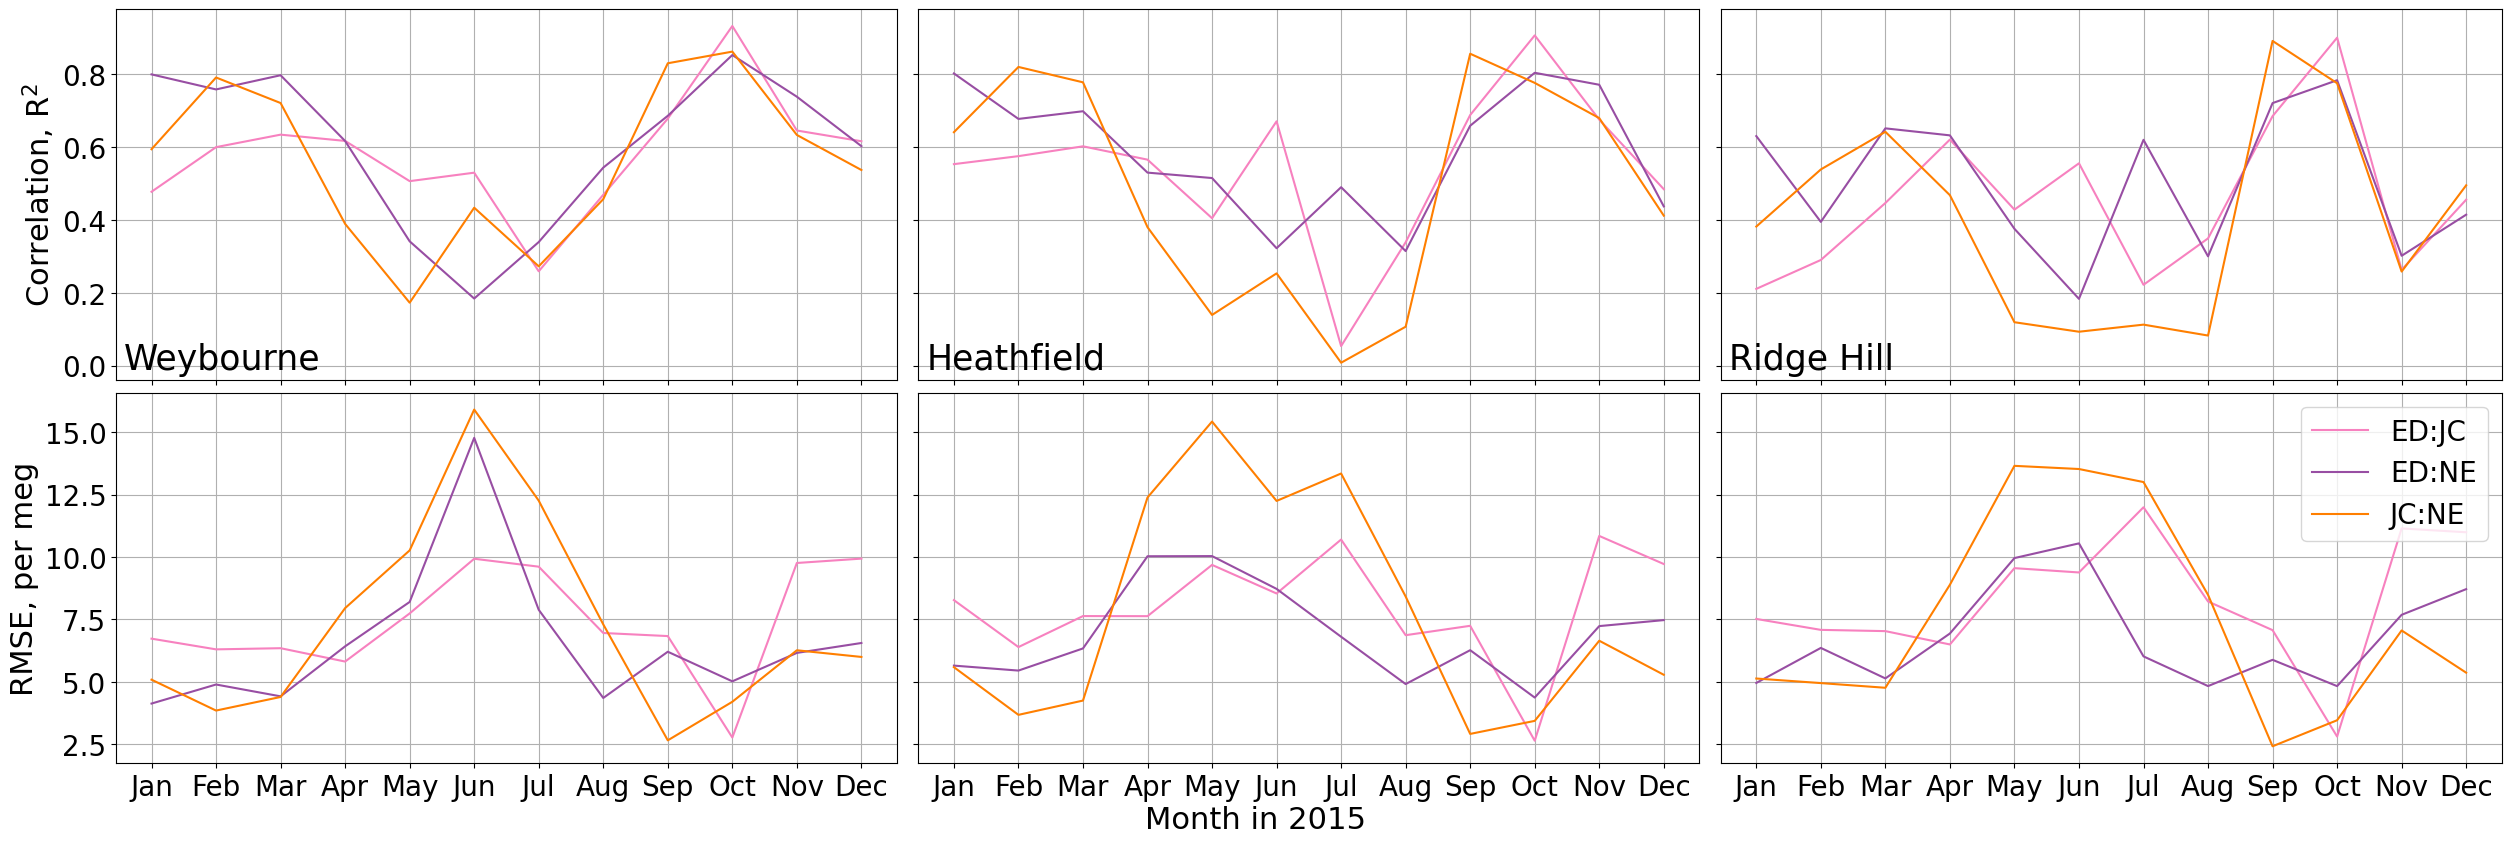

In [28]:
sites_plot = ['WAO', 'HFD', 'RGL']

plot_info_corr = {'unfiltered': {'ls':'-',
                                     'correlation': correlations_models,
                                     'rmse': rmse_models,
                                     'color': {'ecco-jena': '#f781bf', 'ecco-nemo': '#984ea3', 'jena-nemo': '#ff7f00'}}
    }

ncols = len([site for site in sites if site in sites_plot])
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(25, 8), sharex=True, sharey='row', constrained_layout=True)

for info in plot_info_corr.values():
    corr_plot = [[axes.flatten()[ss].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in info['correlation'][site].values()],
                                          label=f'{apo_plot_info.model_names[sim.split("-")[0]]}:{apo_plot_info.model_names[sim.split("-")[1]]}',
                                          ls=info['ls'], color=info['color'][sim])
                  for sim in info['correlation'][site][1].keys()]
                 for ss, site in enumerate(sites) if site in sites_plot]

    rmse_plot = [[axes.flatten()[ss+len(sites)].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in info['rmse'][site].values()],
                                                     label=f'{apo_plot_info.model_names[sim.split("-")[0]]}:{apo_plot_info.model_names[sim.split("-")[1]]}',
                                                     ls=info['ls'], color=info['color'][sim])
                  for sim in info['correlation'][site][1].keys()]
                 for ss, site in enumerate(sites) if site in sites_plot]

ticks = [ax.tick_params(labelsize=20) for ax in axes.flatten()]
grid = [ax.grid() for ax in axes.flatten()]
xlabels = [ax.set_xlabel('') for ax in axes.flatten()]
xlabel = fig.text(0.5, 0, f'Month in {year}', va='top', ha='center', fontsize=22)
    
if len(sites_plot)>1 and len(sites)>1:
    legend = axes[1][-1].legend(loc="upper right", fontsize=20)
    ylabels = [axes[ll][0].set_ylabel(label, fontsize=22)
               for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]
    [axes[0][ss].text(0.01, 0.01, site_text, va='bottom', transform=axes[0][ss].transAxes, fontsize=25) for ss, site_text in enumerate(sites.values())]
else:
    legend = axes[0].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=20)
    ylabels = [axes[ll].set_ylabel(label, fontsize=25)
               for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]

date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                        f'APO_modelcorrelations_{"-".join(sites_plot)}_{date_str}.png')

if save: 
    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Compare the models and observations

### Calculate the R2 and RMSE

In [29]:
rmse = {site: {month: {model.lower(): (((apo_sim.sel(time=slice(start_dates[month], end_dates[month])) - 
                                         apo_obs_year[site].mf.sel(time=slice(start_dates[month], end_dates[month])))**2).mean().values)**0.5
                       for model, apo_sim in apo_site.items() if len(apo_obs_year[site].sel(time=slice(start_dates[month], end_dates[month])))>0}
               for month, start in enumerate(start_dates)}
        for site, apo_site in apo_model.items()}

correlations = {site: {month: {model.lower(): float(xr.corr(apo_obs_year[site].mf.sel(time=slice(start_dates[month], end_dates[month])),
                                                            apo_sim.sel(time=slice(start_dates[month], end_dates[month]))))**2
                               for model, apo_sim in apo_site.items() if len(apo_obs[site].sel(time=slice(start_dates[month], end_dates[month])))>0}
                       for month, start in enumerate(start_dates)}
                for site, apo_site in apo_model.items()}


In [40]:
print('RMSE')
print_rmse = [[print(f'{site}, {apo_plot_info.month_names[month]} rmse:    ECCO: {rmse_month["ecco"]:.2f};   Jena: {rmse_month["jena"]:.2f};   '+
                     f'NEMO: {rmse_month["nemo"]:.2f};     average: {np.array(list(rmse_month.values())).mean():.2f}')
               for month, rmse_month in rmse_site.items() if len(rmse_month)>0]
              for site, rmse_site in rmse.items()]
print('\nCorrelation')
                                                                                   CCO: {corr_month["ecco"]:.2f};   Jena: {corr_month["jena"]:.2f};   '+
                     f'NEMO: {corr_month["nemo"]:.2f};     average: {np.array(list(corr_month.values())).mean():.2f}')
               for month, corr_month in corr_site.items() if len(corr_month)>0]
              for site, corr_site in correlations.items()]

RMSE
WAO, Jan rmse:    ECCO: 9.00;   Jena: 9.61;   NEMO: 9.86;     average: 10.09
WAO, Feb rmse:    ECCO: 13.31;   Jena: 16.77;   NEMO: 16.99;     average: 17.42
WAO, Mar rmse:    ECCO: 8.80;   Jena: 8.41;   NEMO: 8.72;     average: 8.81
WAO, Apr rmse:    ECCO: 9.90;   Jena: 10.68;   NEMO: 10.94;     average: 10.61
WAO, May rmse:    ECCO: 9.82;   Jena: 10.22;   NEMO: 11.25;     average: 10.85
WAO, Jun rmse:    ECCO: 15.72;   Jena: 18.97;   NEMO: 16.02;     average: 17.86
WAO, Jul rmse:    ECCO: 9.50;   Jena: 11.71;   NEMO: 12.93;     average: 11.49
WAO, Aug rmse:    ECCO: 7.58;   Jena: 10.12;   NEMO: 8.79;     average: 8.98
WAO, Sep rmse:    ECCO: 13.00;   Jena: 11.50;   NEMO: 11.43;     average: 11.98
WAO, Oct rmse:    ECCO: 7.83;   Jena: 8.25;   NEMO: 6.96;     average: 7.75
WAO, Nov rmse:    ECCO: 5.31;   Jena: 7.11;   NEMO: 6.28;     average: 6.62
WAO, Dec rmse:    ECCO: 5.96;   Jena: 6.58;   NEMO: 6.75;     average: 7.01

Correlation
WAO, Jan correlation:    ECCO: 0.17;   Jena: 0.

### Rearrange correlations dictionary

Rearrange to group all model correlations together:\
i.e. so that the 1st key is the model, and then the 2nd key is the month

e.g.:\
{'ECCO': {1: corr_1, 2: corr_2, etc.}}

In [30]:
corr = {}
for month, model_corrs in correlations['WAO'].items():
    for model, model_corr in model_corrs.items():
        if model not in corr.keys():
            corr[model] = {}
        corr[model][month] = float(model_corr)
rmse_ = {}
for month, model_rmses in rmse['WAO'].items():
    for model, model_rmse in model_rmses.items():
        if model not in rmse_.keys():
            rmse_[model] = {}
        rmse_[model][month] = float(model_rmse)

### Calculate average correlation for a season

In [31]:
corr_seasons = {season: {model: [corr_model[month] for month in season_months]
                         for model, corr_model in corr.items()}
                for season, season_months in apo_plot_info.seasons.items()}
corr_seasons_ave = {season: {model: np.nanmean(np.array(corr_model))
                             for model, corr_model in corr_season.items()}
                    for season, corr_season in corr_seasons.items()}
corr_seasons_ave

for season, corr_season in corr_seasons_ave.items():
    print(f'{season}:')
    [print(f'       {model}: {corr_model:.2f}') for model, corr_model in corr_season.items()]

Spring:
       ecco: 0.37
       jena: 0.38
       nemo: 0.27
       no ocean: 0.29
Summer:
       ecco: 0.17
       jena: 0.03
       nemo: 0.04
       no ocean: 0.02
Autumn:
       ecco: 0.34
       jena: 0.26
       nemo: 0.31
       no ocean: 0.32
Winter:
       ecco: 0.36
       jena: 0.25
       nemo: 0.29
       no ocean: 0.43


### Calculate annual average correlations

In [37]:
print(f'average correlation: {np.nanmean([np.nanmean(list(corr_model.values())) for model, corr_model in corr.items()]):.2f}')
print(f'average RMSE: {np.nanmean([np.nanmean(list(rmse_model.values())) for model, rmse_model in rmse_.items()]):.2f}')

average correlation: 0.26
average RMSE: 11.86


## Apply masks

Filter data for only daytime values

In [32]:
apo_model_day = {site: {month: {sim: apo_filter.filter_time(dataset = apo_sim,
                                                            site = 'WAO',
                                                            hour_start = 11,
                                                            hour_end = 15)
                                for sim, apo_sim in apo_month.items() if len(apo_month)>0}
                        for month, apo_month in apo_site.items()}
                 for site, apo_site in apo_model.items()}
apo_obs_day = {month: {site: apo_filter.filter_time(dataset = apo_site.mf,
                                                    site = 'WAO',
                                                    hour_start = 11,
                                                    hour_end = 15)
                       for site, apo_site in apo_month.items() if len(apo_site)>0}
               for month, apo_month in apo_obs.items()}

In [33]:
rmse_day = {site: {month: {model.lower(): (((apo_sim.sel(time=slice(start_dates[month], end_dates[month])) - 
                                     apo_obs[month][site].mf.sel(time=slice(start_dates[month], end_dates[month])))**2).mean().values)**0.5
                       for model, apo_sim in apo_month.items() if len(apo_obs[month][site])>0}
               for month, apo_month in apo_site.items()}
        for site, apo_site in apo_model_day.items()}

correlations_day = {site: {month: {model.lower(): xr.corr(apo_obs[month][site].mf.sel(time=slice(start_dates[month], end_dates[month])),
                                                  apo_sim.sel(time=slice(start_dates[month], end_dates[month])))**2
                               for model, apo_sim in apo_month.items() if len(apo_obs[month][site])>0}
                       for month, apo_month in apo_site.items()}
                for site, apo_site in apo_model_day.items()}

In [44]:
print('RMSE')
print_rmse = [[print(f'{site}, {apo_plot_info.month_names[month]} rmse:    ECCO: {rmse_month["ecco"]:.2f};   ' +
                     f'Jena: {rmse_month["jena"]:.2f};   NEMO: {rmse_month["nemo"]:.2f};     average: {np.array(list(rmse_month.values())).mean():.2f}')
               for month, rmse_month in rmse_site.items() if len(rmse_month)>0]
              for site, rmse_site in rmse_day.items()]
print('\nCorrelation')
print_corr = [[print(f'{site}, {apo_plot_info.month_names[month]} correlation:    ECCO: {corr_month["ecco"]:.2f};   Jena: {corr_month["jena"]:.2f};   ' +
                     f'NEMO: {corr_month["nemo"]:.2f};     average: {np.array(list(corr_month.values())).mean():.2f}')
               for month, corr_month in corr_site.items() if len(corr_month)>0]
              for site, corr_site in correlations_day.items()]

RMSE
WAO, Jan rmse:    ECCO: 9.14;   Jena: 9.56;   NEMO: 9.70;     average: 10.10
WAO, Feb rmse:    ECCO: 11.52;   Jena: 16.94;   NEMO: 16.87;     average: 17.27
WAO, Mar rmse:    ECCO: 8.44;   Jena: 7.72;   NEMO: 8.65;     average: 8.44
WAO, Apr rmse:    ECCO: 9.98;   Jena: 10.22;   NEMO: 9.95;     average: 10.32
WAO, May rmse:    ECCO: 8.99;   Jena: 9.48;   NEMO: 11.51;     average: 10.33
WAO, Jun rmse:    ECCO: 17.25;   Jena: 17.26;   NEMO: 17.27;     average: 17.44
WAO, Jul rmse:    ECCO: 10.41;   Jena: 11.30;   NEMO: 12.57;     average: 11.38
WAO, Aug rmse:    ECCO: 8.09;   Jena: 9.04;   NEMO: 9.23;     average: 8.81
WAO, Sep rmse:    ECCO: 13.62;   Jena: 12.16;   NEMO: 12.10;     average: 12.64
WAO, Oct rmse:    ECCO: 8.98;   Jena: 9.56;   NEMO: 7.61;     average: 8.80
WAO, Nov rmse:    ECCO: 4.53;   Jena: 6.47;   NEMO: 5.77;     average: 6.07
WAO, Dec rmse:    ECCO: 4.96;   Jena: 5.33;   NEMO: 6.04;     average: 6.22

Correlation
WAO, Jan correlation:    ECCO: 0.05;   Jena: 0.04

### Mask high ocean contributions

We use the footprint to mask times when there is a high ocean contribution:
- To do this we mask the ocean part of the footprint and take the sum.
- Then we take the sum of the unmasked footprint.
- We use this to find the proportion of the footprint that is across the land.
- Finally, we set a limit for the proportion of footprint which must be across the land, below which we filter out the model


### Import the footprints

In [34]:
footprints = {month: name.footprints(sitecode_or_filename='WAO',
                                     met_model='UKV',
                                     start=start,
                                     end=end_dates[month],
                                     domain='EUROPE')
              for month, start in start_dates.items()}

No lifetime defined in species_info.json or species not defined. WARNING: 30-day integrated footprint used without chemical loss.
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_EUROPE_201501.nc
No lifetime defined in species_info.json or species not defined. WARNING: 30-day integrated footprint used without chemical loss.
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_EUROPE_201502.nc
No lifetime defined in species_info.json or species not defined. WARNING: 30-day integrated footprint used without chemical loss.
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_EUROPE_201503.nc
No lifetime defined in species_info.json or species not defined. WARNING: 30-day integrated footprint used without chemical loss.
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_EUROPE_201504.nc
No lifetime defined in species_info.json or spec

### Find the land proportion of the footprints

- Define a mask for land vs ocean and mask out the ocean
- Take the sum of both the masked and unmasked footprints, and divide

In [35]:
mask_path = os.path.join(Paths.lpdm, 'countries')
mask_file = glob.glob(os.path.join(mask_path, 'land-ocean_EUROPE*'))[0]
mask = name.open_ds(mask_file).land_ocean_mask

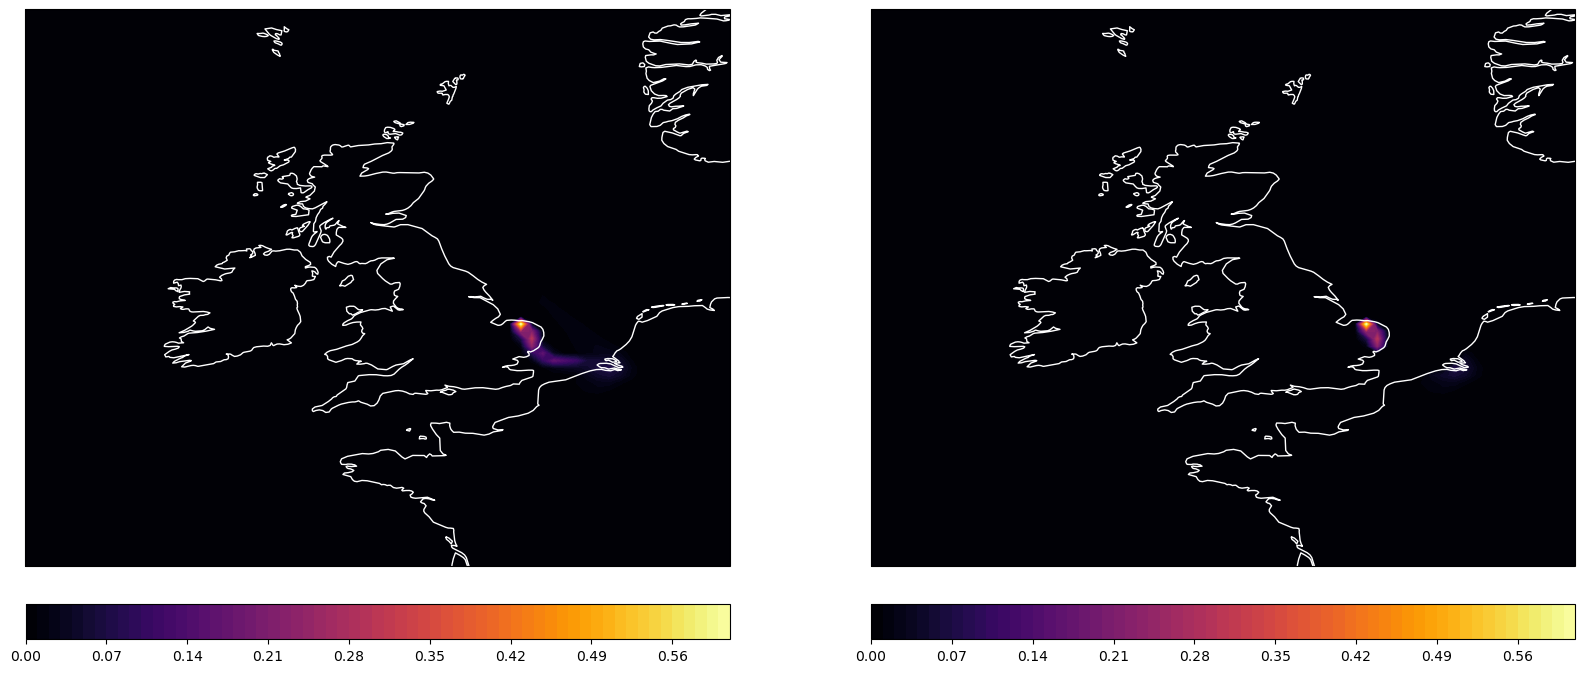

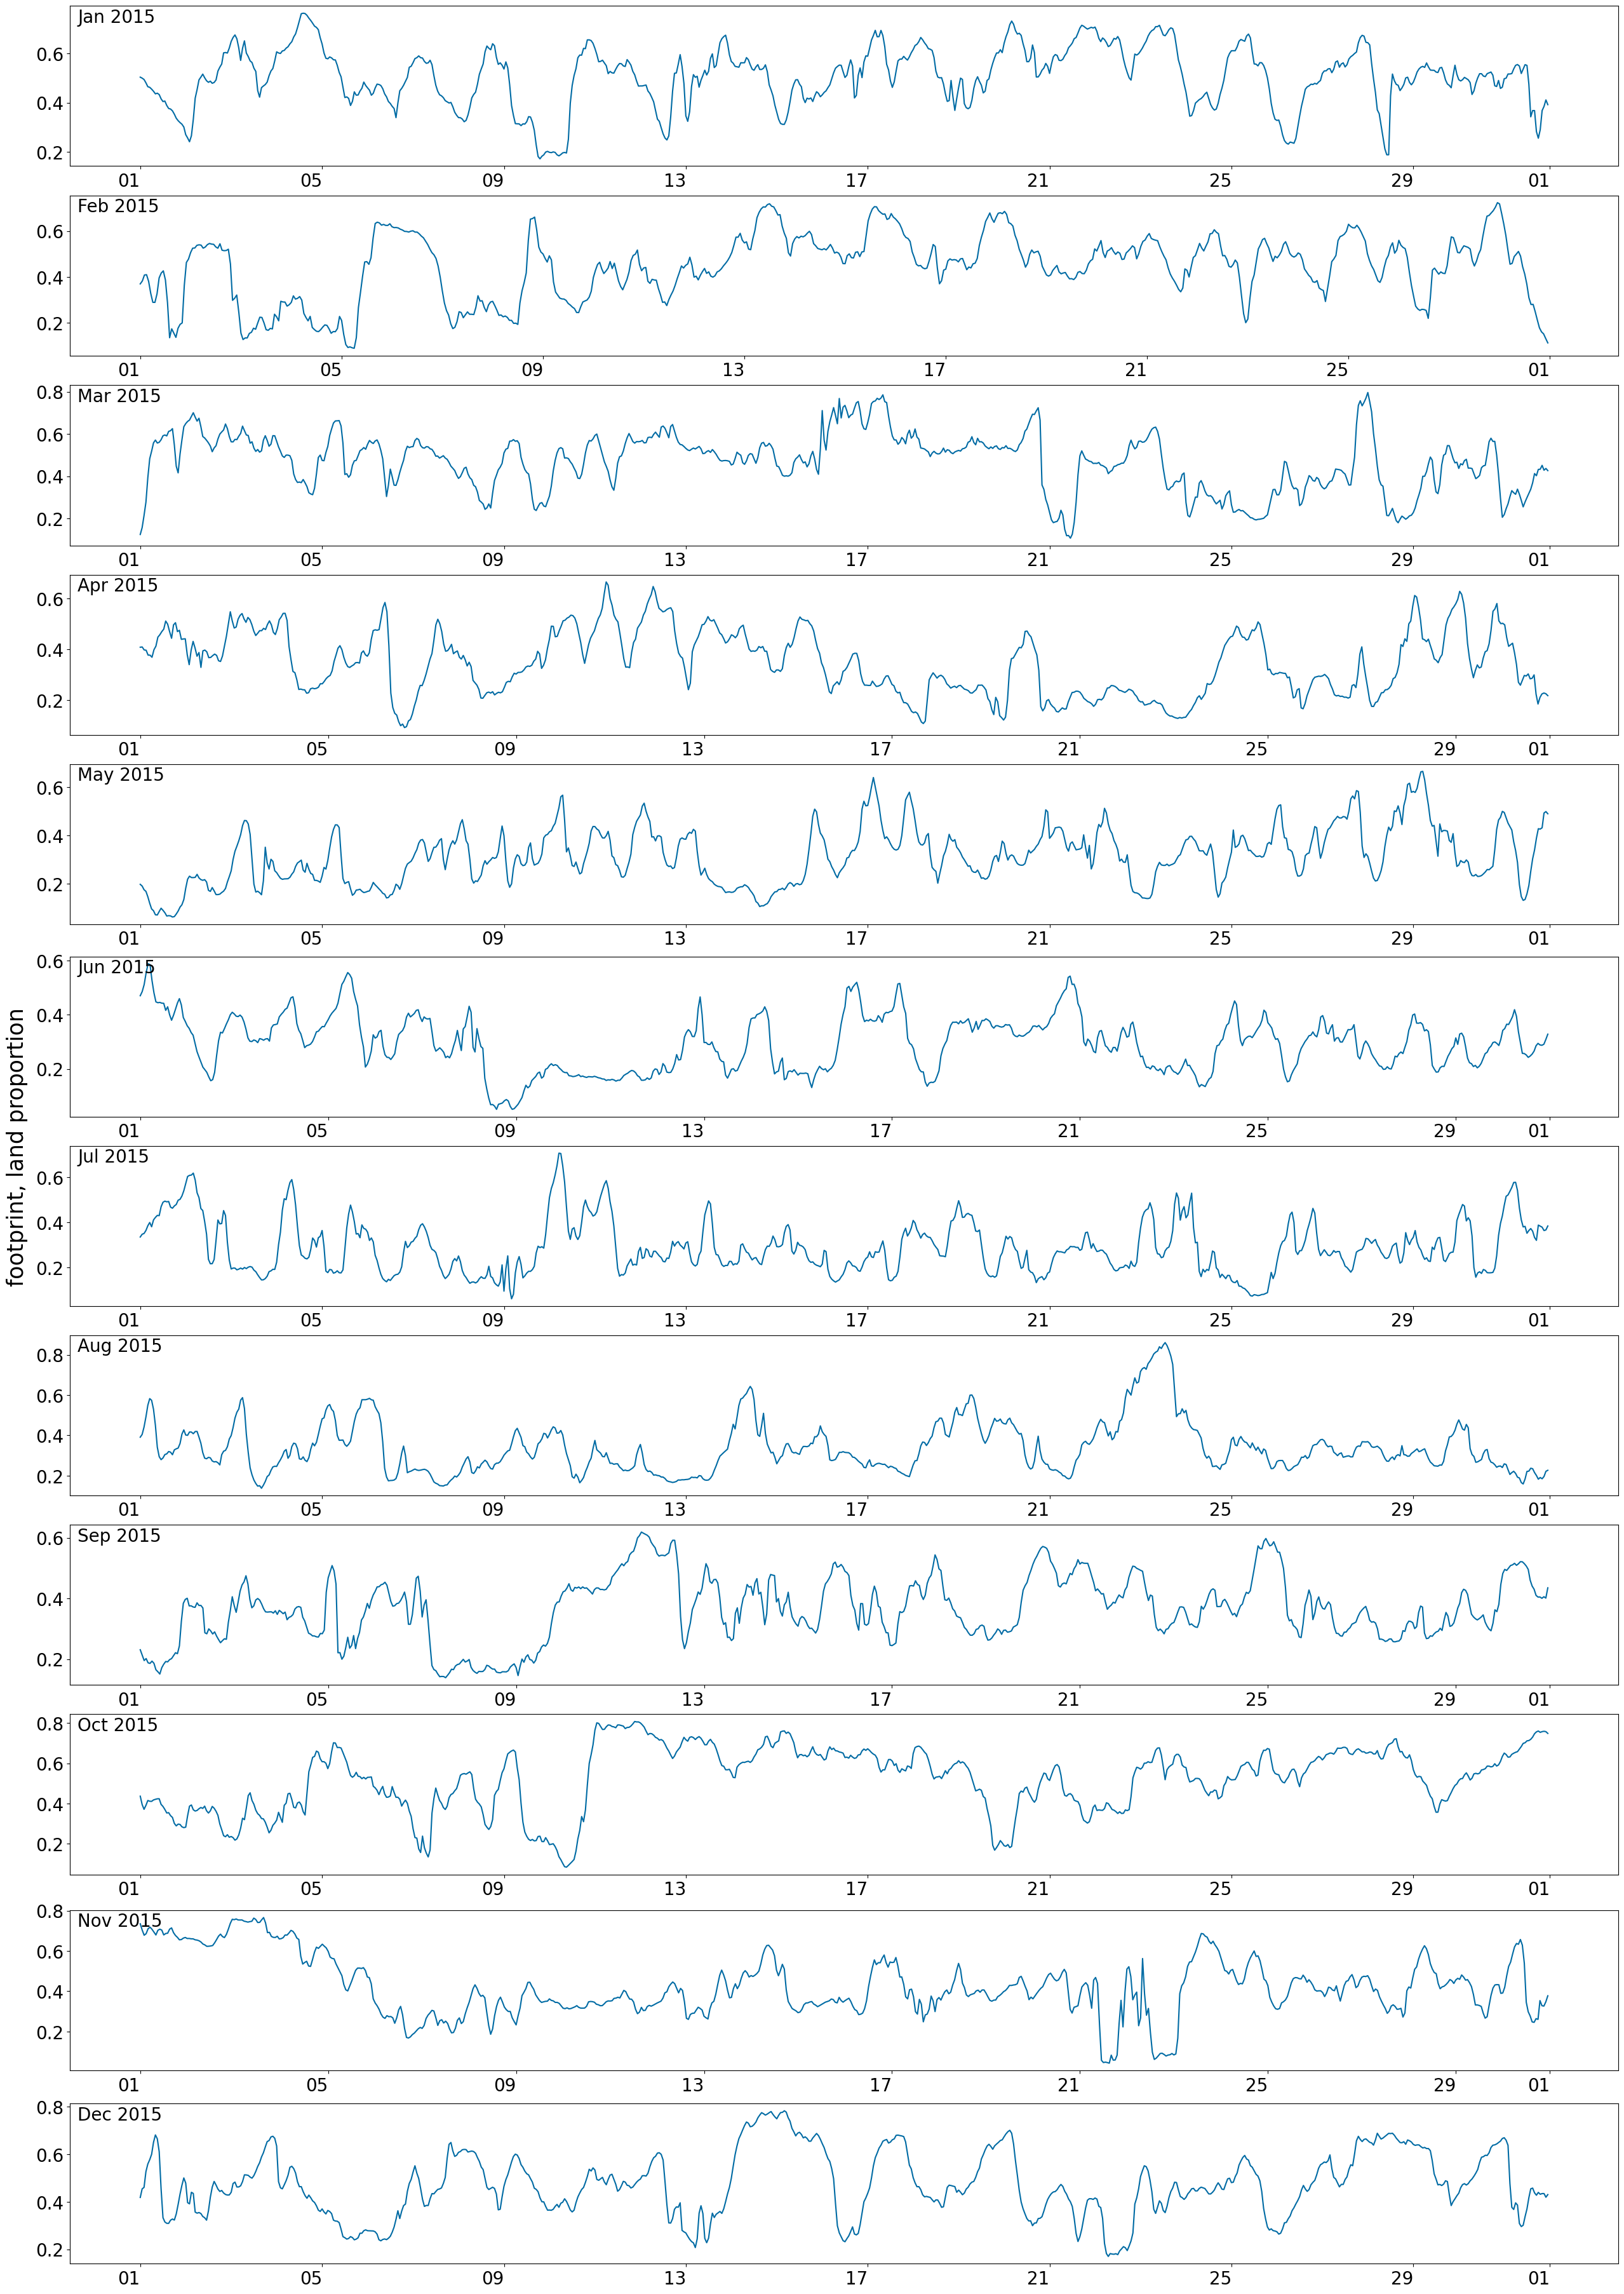

In [36]:
# basins = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50
# mask = basins.mask(footprints[months[0]].lon, footprints[months[0]].lat)

# fp_masked = {month: footprint.fp.where(mask.isnull())
#              for month, footprint in footprints.items()}

fp_masked = {month: footprint.fp*mask
             for month, footprint in footprints.items()}
fp_proportion_land = {month: fp_masked[month].sum(dim=['lat', 'lon']) / fp_month.fp.sum(dim=['lat', 'lon'])
                      for month, fp_month in footprints.items()}

fig, ax = apo_funcs.show_map(data=[footprints[8].fp[:,:,0], fp_masked[8][:,:,0]],
                             crop_uk=True,
                             coast_color='white')
fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(25, 3*len(months)), constrained_layout=True)
plots_proportions = [fp_prop.plot(ax=axes[ff]) for ff, fp_prop in enumerate(fp_proportion_land.values())]

xlabels = [ax.set_xlabel('') for ax in axes]
ylabels = [ax.set_ylabel('') for ax in axes]
ylabel = fig.text(-0.01, 0.5, 'footprint, land proportion', va='center', ha='center', rotation='vertical', fontsize=25)
# format the tick labels to take up less space: just show the day number
myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
# add a label for the month and year
text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}',
                      transform=axes[mm].transAxes, va='top', fontsize=20)
        for mm, month in enumerate(months)]

### Mask the APO model

Set a limit for the minimum proportion of footprint which must come across the land and use this to filter out times with large ocean influence

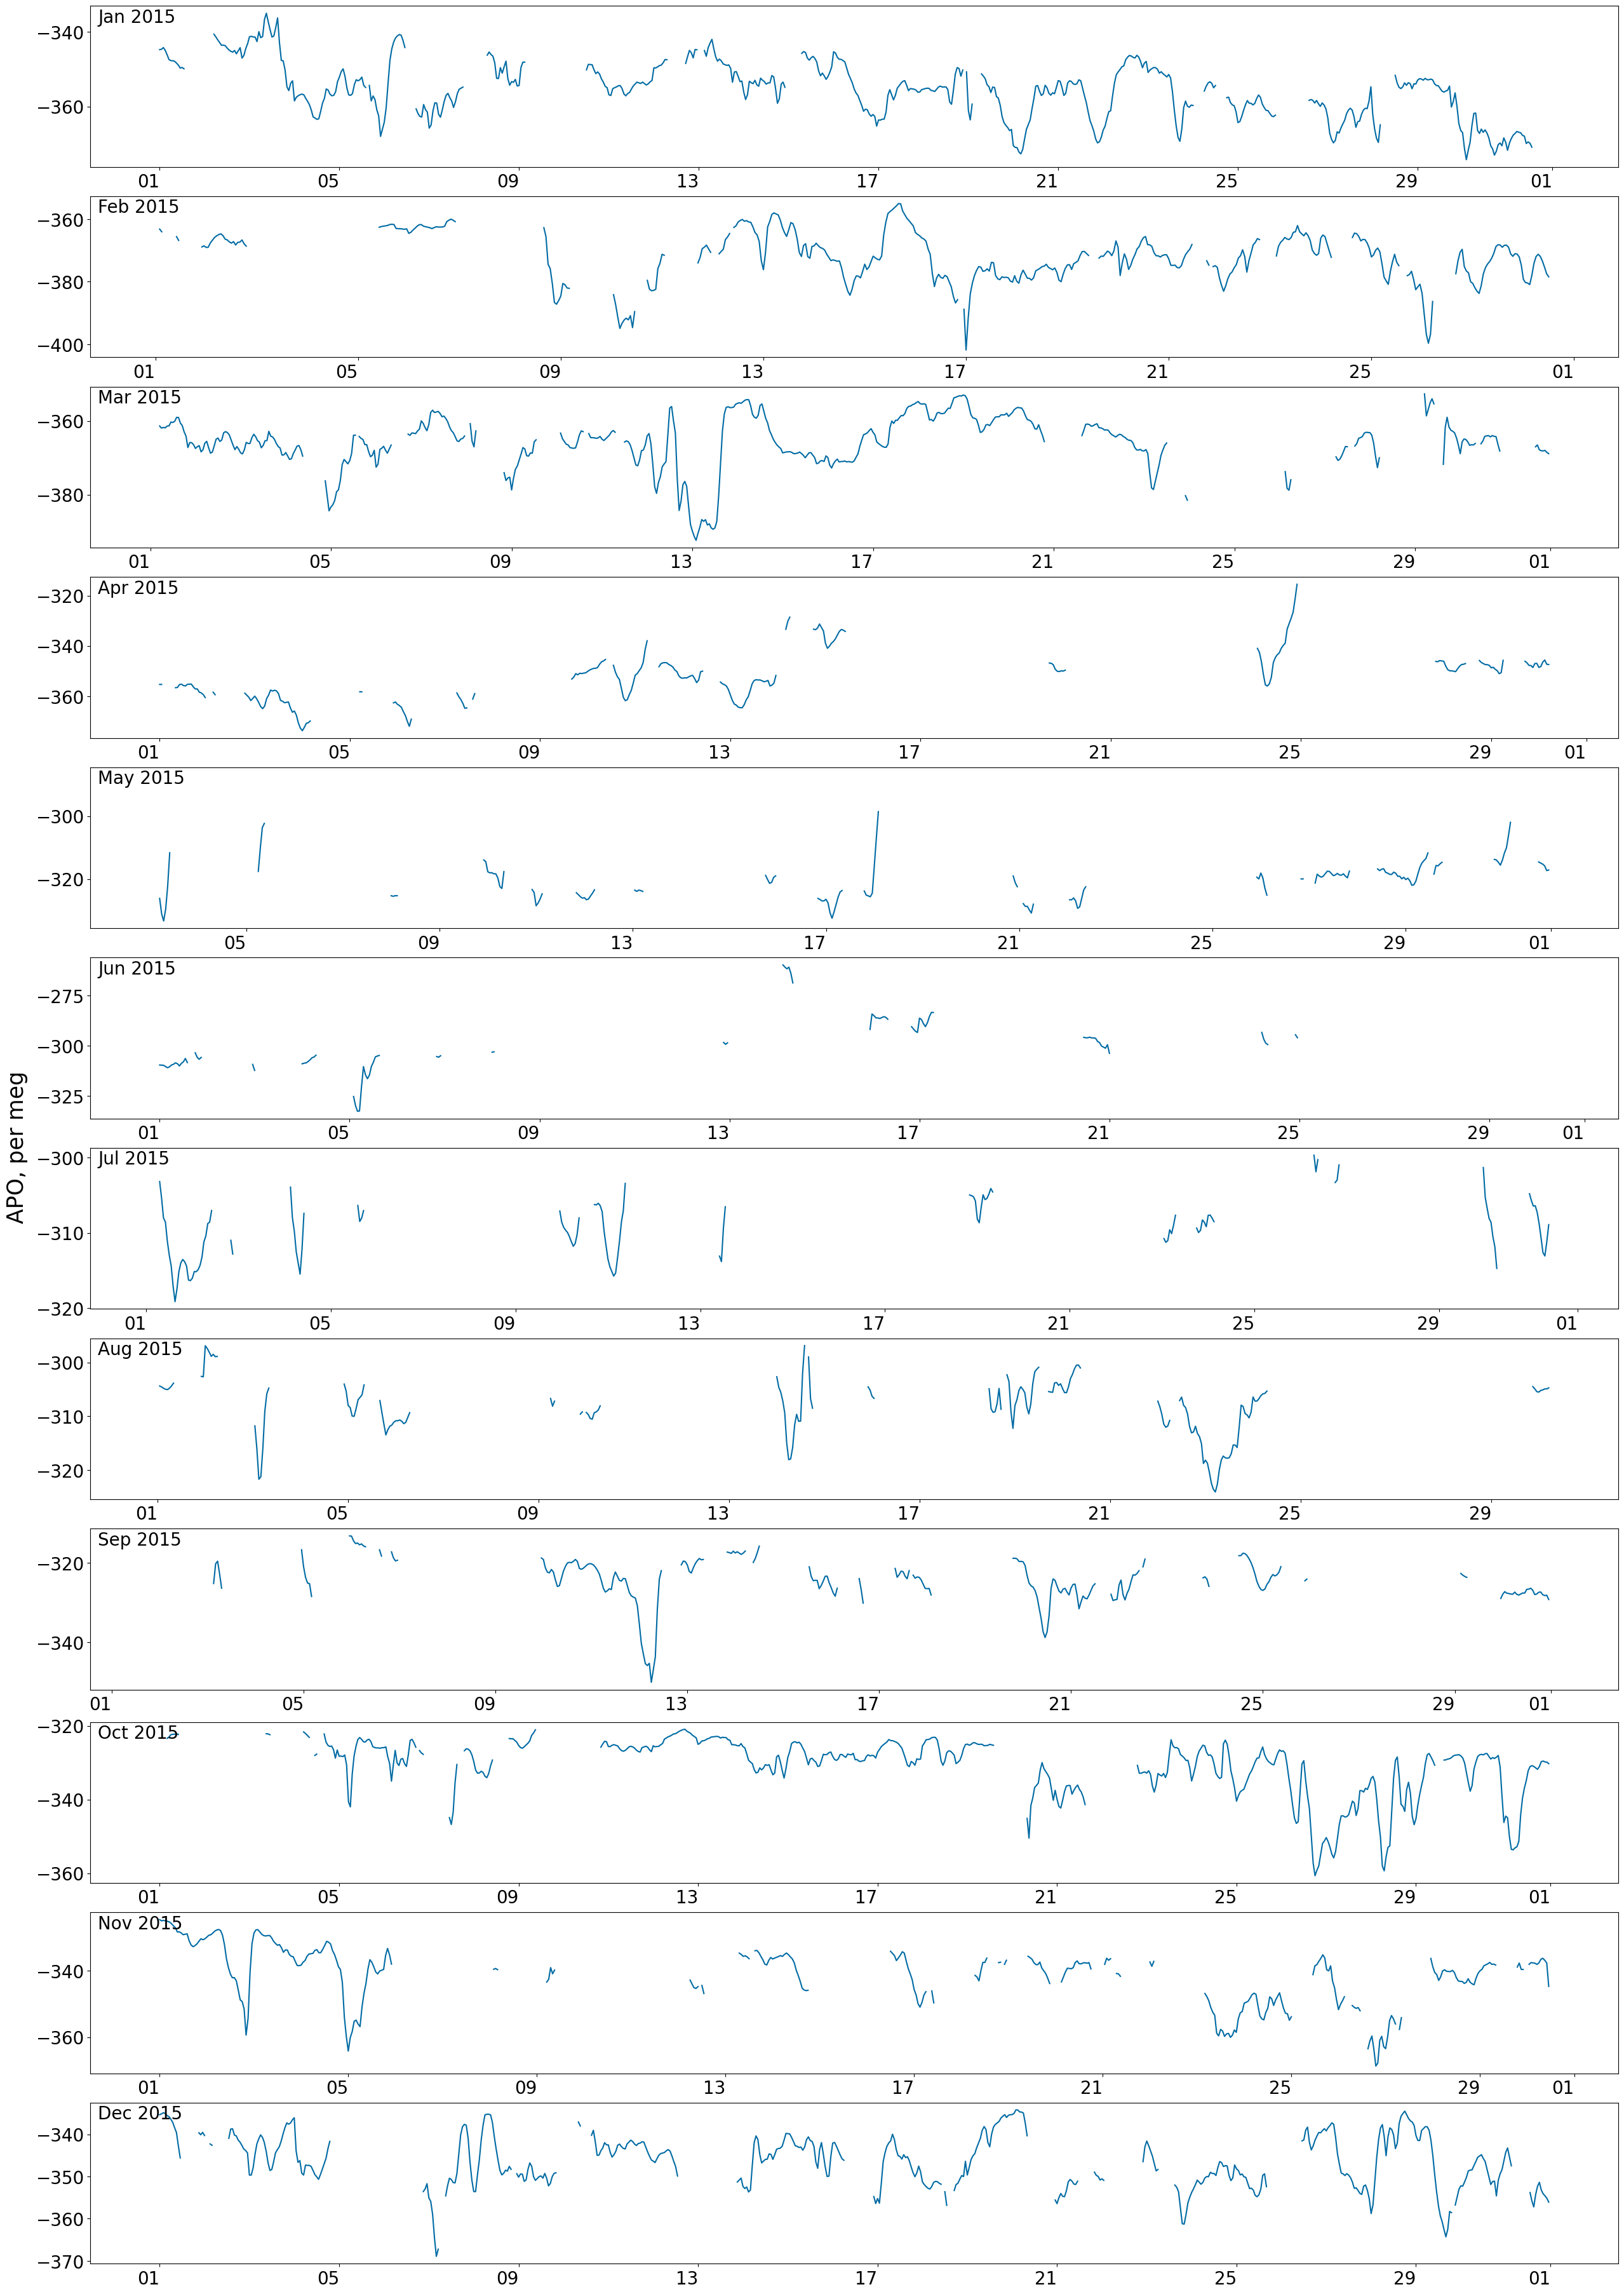

In [37]:
proportion_limit = 0.4

apo_ocean_masked = {site: {month: {model: apo_model.where(fp_proportion_land[month]>proportion_limit)
                                   for model, apo_model in apo_month.items()}
                           for month, apo_month in apo_site.items()}
                    for site, apo_site in apo_model.items()}

# plot the APO model with high ocean footprints masked
fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(25, 3*len(months)), constrained_layout=True)
plots_apo = [apo['NEMO'].plot(ax=axes[aa]) for aa, apo in enumerate(apo_ocean_masked['WAO'].values())]
xlabels = [ax.set_xlabel('') for ax in axes]
ylabel = fig.text(-0.01, 0.5, 'APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)

# format the tick labels to take up less space: just show the day number
myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
# add a label for the month and year
text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}',
                      transform=axes[mm].transAxes, va='top', fontsize=20)
        for mm, month in enumerate(months)]

### Calculate the correlations and RMSE

Do this for each:

- site,
- month,
- ocean flux.

In [38]:
rmse_land = {site: {month: {model.lower(): (((apo_sim.sel(time=slice(start_dates[month], end_dates[month])) - 
                                      apo_obs[month][site].mf.sel(time=slice(start_dates[month], end_dates[month])))**2).mean().values)**0.5
                            for model, apo_sim in apo_month.items() if len(apo_obs[month][site])>0}
                    for month, apo_month in apo_site.items()}
             for site, apo_site in apo_ocean_masked.items()}

correlations_land = {site: {month: {model.lower(): xr.corr(apo_obs[month][site].mf.sel(time=slice(start_dates[month], end_dates[month])),
                                                   apo_sim.sel(time=slice(start_dates[month], end_dates[month])))**2
                                    for model, apo_sim in apo_month.items() if len(apo_obs[month][site])>0}
                            for month, apo_month in apo_site.items()}
                      for site, apo_site in apo_ocean_masked.items()}

In [45]:
print('RMSE')
print_rmse = [[print(f'{site}, {apo_plot_info.month_names[month]} rmse:    ECCO: {rmse_month["ecco"]};   ' +
                     f'Jena: {rmse_month["jena"]};   NEMO: {rmse_month["nemo"]}; average: {np.array(list(rmse_month.values())).mean()}')
               for month, rmse_month in rmse_site.items() if len(rmse_month)>0]
              for site, rmse_site in rmse_land.items()]
print('\nCorrelation')
print_corr = [[print(f'{site}, {apo_plot_info.month_names[month]} correlation:    ECCO: {corr_month["ecco"].values};   Jena: {corr_month["jena"].values};   ' +
                     f'NEMO: {corr_month["nemo"].values}; average: {np.array(list(corr_month.values())).mean()}')
               for month, corr_month in corr_site.items() if len(corr_month)>0]
              for site, corr_site in correlations_land.items()]

RMSE
WAO, Jan rmse:    ECCO: 13.387229487976903;   Jena: 10.240396376419502;   NEMO: 8.638400341334705; average: 9.757779489547831
WAO, Feb rmse:    ECCO: 23.916894866336428;   Jena: 17.05180718038488;   NEMO: 16.264277381084202; average: 16.943258892437193
WAO, Mar rmse:    ECCO: 14.985851528224707;   Jena: 11.843921386073545;   NEMO: 11.249931419114384; average: 11.77688356786711
WAO, Apr rmse:    ECCO: 12.437473263792391;   Jena: 11.848510402058254;   NEMO: 12.009146767231625; average: 12.11893909903756
WAO, May rmse:    ECCO: 11.766505414196967;   Jena: 10.800981658765;   NEMO: 14.453133596733716; average: 11.855781302872476
WAO, Jun rmse:    ECCO: nan;   Jena: nan;   NEMO: nan; average: nan
WAO, Jul rmse:    ECCO: 9.005026450430677;   Jena: 9.34174780077122;   NEMO: 12.350915187705008; average: 9.923114957450414
WAO, Aug rmse:    ECCO: 6.447261721325929;   Jena: 7.017492023795716;   NEMO: 9.600384289299488; average: 7.486571792966544
WAO, Sep rmse:    ECCO: 9.824677426559385;   Je

### Plot correlations

If there is a whole year of data then we plot the correlations and RMSE

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_correlations_WAO_2015.png


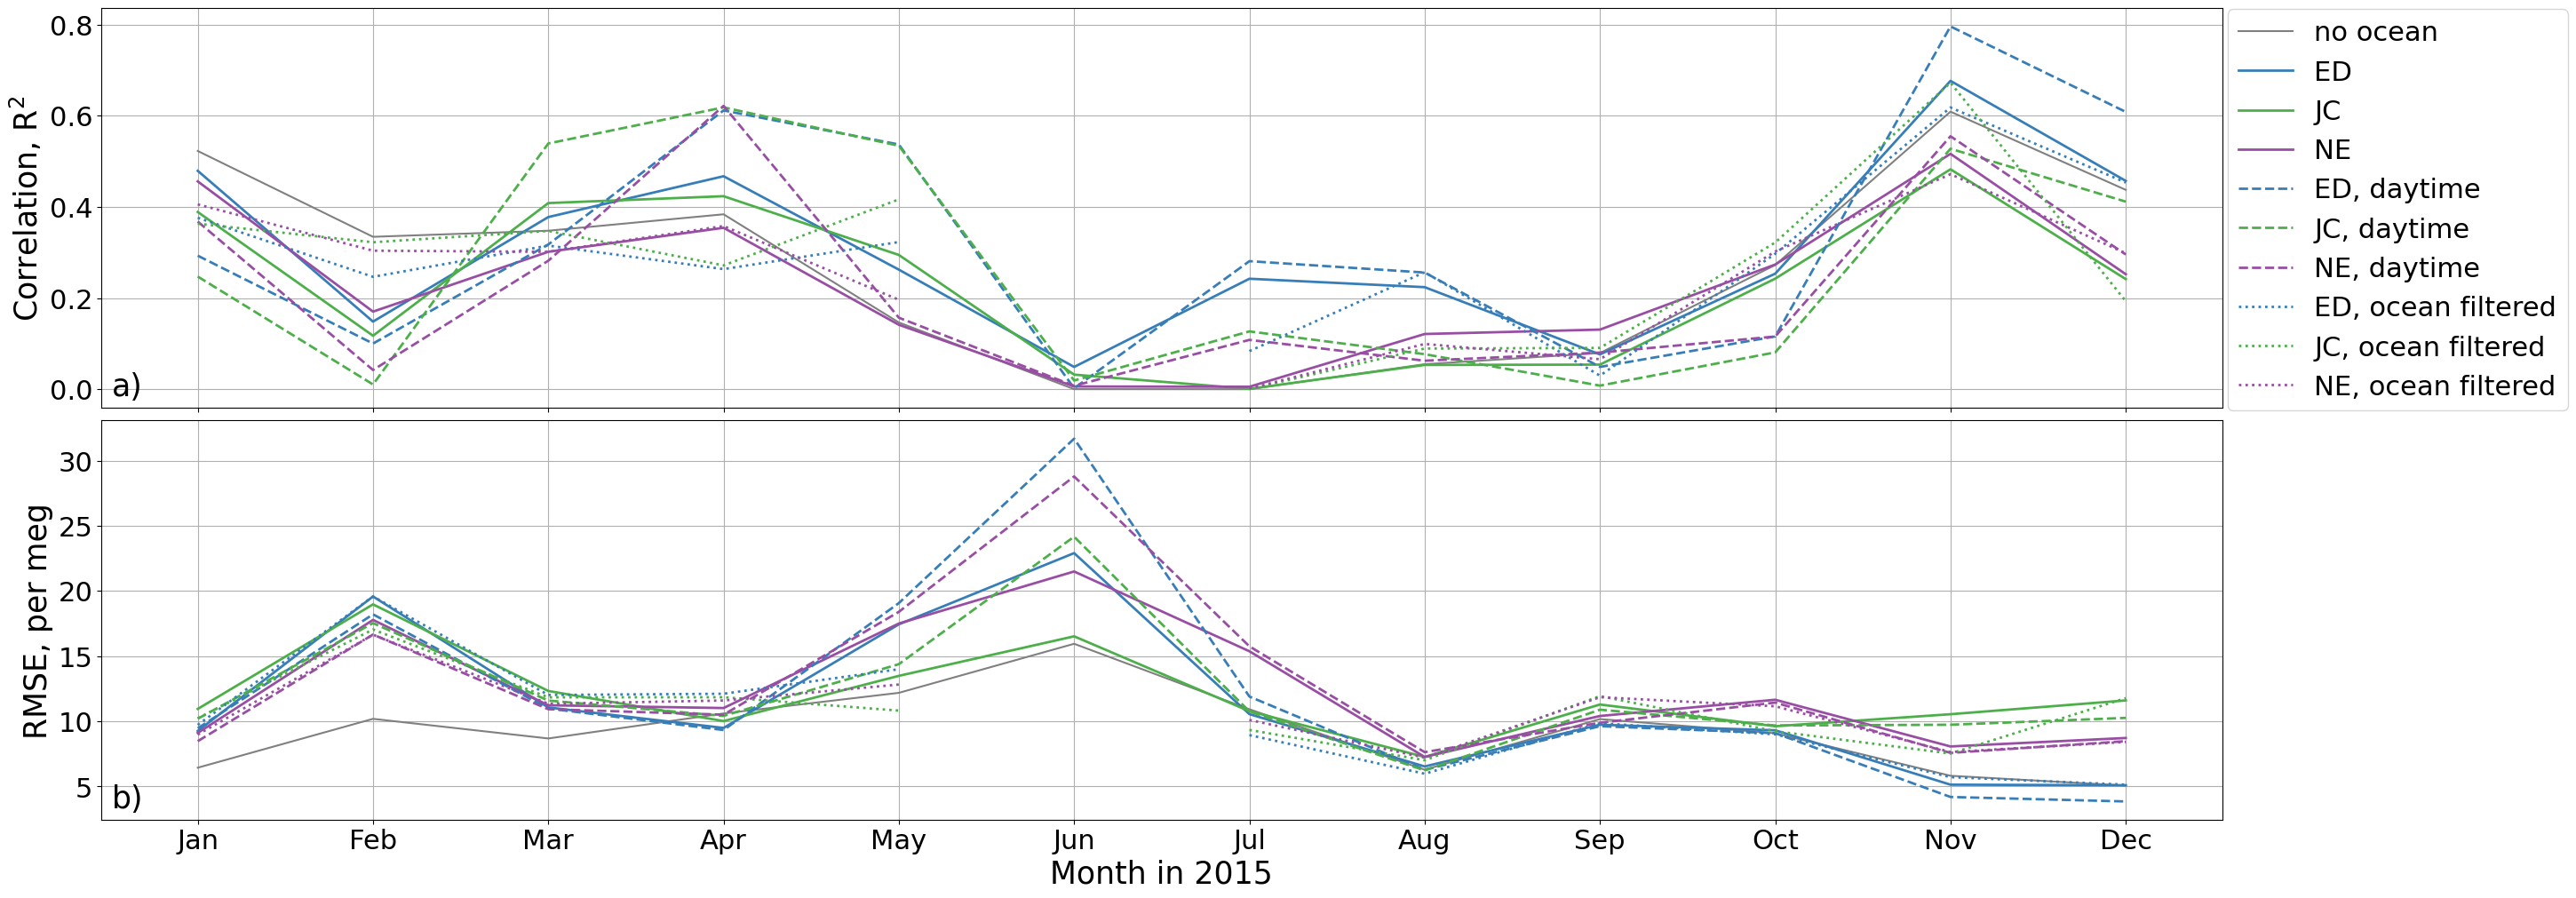

In [39]:
if len(months)>=12:
    sites_plot = ['WAO']
    sites_plot = [site for site in sites_plot if site in sites]

    plot_info_corr = {'unfiltered': {'label': '', 'ls':'-',
                                    'correlation': correlations,
                                    'rmse': rmse},
                      'daytime': {'label': ', daytime', 'ls': '--',
                                  'correlation': correlations_day,
                                  'rmse': rmse_day},
                      'land': {'label': ', ocean filtered', 'ls': ':',
                               'correlation': correlations_land,
                               'rmse': rmse_land}}

    fig, axes = plt.subplots(nrows=2*len(sites_plot), ncols=1, figsize=(25, 10*len(sites_plot)), sharex=True, constrained_layout=True)

    # plot for the no ocean model
    corr_no_ocean_plot = [axes[ss].plot(apo_plot_info.month_names.values(), [rr['no ocean'] for rr in correlations[site].values()],
                                        color=apo_plot_info.colors['no ocean'], label='no ocean')
                          for ss, site in enumerate(sites_plot)]
    rmse_no_ocean_plot = [axes[len(sites_plot)+ss].plot(apo_plot_info.month_names.values(), [rr['no ocean'] for rr in rmse[site].values()],
                                                        color=apo_plot_info.colors['no ocean'])
                          for ss, site in enumerate(sites_plot)]
    
    # plot for all of the other models
    for info in plot_info_corr.values():
        corr_plot = [[axes[ss].plot(apo_plot_info.month_names.values(), [rr[sim.lower()] for rr in info['correlation'][site].values()],
                                    color=apo_plot_info.colors[sim.lower()], label=f'{apo_plot_info.model_names[sim.lower()]}{info["label"]}', ls=info['ls'], lw=2)
                     for sim in ocean_sims] for ss, site in enumerate(sites_plot)]

    for info in plot_info_corr.values():
        rmse_plot = [[axes[len(sites_plot)+ss].plot(apo_plot_info.month_names.values(), [rr[sim.lower()] for rr in info['rmse'][site].values()],
                                                    color=apo_plot_info.colors[sim.lower()], ls=info['ls'], lw=2)
                     for sim in ocean_sims] for ss, site in enumerate(sites_plot)]

    ticks = [ax.tick_params(labelsize=22) for ax in axes]
    # legend = axes[0].legend(loc='lower left', fontsize=16)
    # legend = axes[0].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=20)
    # add the legend outside of the axis, this way allows the legend to go over the y-area of one axis
    legend = fig.legend(bbox_to_anchor=(1.16, 1.01), fontsize=22)
    grid = [ax.grid() for ax in axes]
    xlabels = [ax.set_xlabel('') for ax in axes]
    xlabel = axes[1].set_xlabel(f'Month in {year}', fontsize=25)
    ylabels = [axes[ll].set_ylabel(label, fontsize=25)
               for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]
    ax_labels = [ax.text(0.005, 0.015, f'{chr(97+aa)})', va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

    # save the figure
    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'APO_correlations_{"-".join(sites_plot)}_{date_str}.png')
    
    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

In [ ]:
for sim in ocean_sims:
    for month in months:
        print(f'{sim}, {month}:    ' + \
              f'Unfiltered: {float(correlations["WAO"][month][sim]):.2f};    ' + \
              f'Daytime: {float(correlations_day["WAO"][month][sim]):.2f};    ' + \
              f'Land: {float(correlations_land["WAO"][month][sim]):.2f}')

## Plot the model and observations

## Average over different time periods

Try averaging over a day, a week, and a month to see how time resolution affects the correlation with the obs

First we rearrange the dictionary; the original dictionary was ordered: {site: {month: {ocean_flux: timeseries}}}.\
We want a dictionary: {site: {ocean_flux: {month: timeseries}}}

Then we concatenate the timeseries for the year to give a dictionary: {site: {ocean_flux: timeseries}}

In [13]:
apo_model_year = {}
for site, apo_site in apo_model.items():
    # rearrange the dictionary keys
    apo_model_year[site] = {}
    for month, apo_month in apo_site.items():
        for ocean, apo_ocean in apo_month.items():
            if ocean not in apo_model_year[site].keys():
                apo_model_year[site][ocean] = {}
            apo_model_year[site][ocean][month] = apo_ocean
    # combine the timeseries for each site and ocean flux
    for model, apo_mod in apo_model_year[site].items():
        apo_model_year[site][model] = xr.concat(list(apo_mod.values()), dim='time')

### Resample the timeseries

Resample the model and obs timeseries to different time resolutions

In [19]:
# resample the model
apo_model_diff_res = {site: {model: {res_name: apo_mod.resample(time=res).mean()
                                     for res_name, res in {'hour': '1H', 'day': '1D', 'week': 'W', 'month': '1M'}.items()}
                             for model, apo_mod in apo_site.items()}
                      for site, apo_site in apo_model_year.items() if len(apo_obs_year[site])>0}
# resample the obs
apo_obs_diff_res = {site: {res_name: apo_site[0].mf.resample(time=res).mean()
                           for res_name, res in {'hour': '1H', 'day': '1D', 'week': 'W', 'month': '1M'}.items()}
                    for site, apo_site in apo_obs_year.items() if len(apo_site)>0}

### Calculate RMSE & Correlations

Calculate the RMSE and Pearson Correlation coefficient for each:

- site,
- month,
- ocean flux estimate,
- time resolution.

In [ ]:
rmse_diff_res = {site: {month: {model: {res: (((apo_res.sel(time=slice(start_dates[month], end_dates[month])) - 
                                                apo_obs_diff_res[site][res].sel(time=slice(start_dates[month], end_dates[month])))**2).mean().values)**0.5
                                        for res, apo_res in apo_sim.items()}
                                for model, apo_sim in apo_site.items() if len(apo_obs[month][site])>0}
                        for month in months}
                for site, apo_site in apo_model_diff_res.items()}

correlations_diff_res = {site: {month: {model: {res: xr.corr(apo_obs_diff_res[site][res].sel(time=slice(start_dates[month], end_dates[month])),
                                                             apo_res.sel(time=slice(start_dates[month], end_dates[month])))**2
                                                for res, apo_res in apo_sim.items()}
                                        for model, apo_sim in apo_site.items() if len(apo_obs[month][site])>0}
                                for month in months}
                         for site, apo_site in apo_model_diff_res.items()}

In [ ]:
print('RMSE')
print_rmse = [[print(f'{site}, {apo_plot_info.month_names[month]} rmse:    hour: {rmse_month["NEMO"]["hour"]:.2f};   ' +
                     f'day: {rmse_month["NEMO"]["day"]:.2f};   week: {rmse_month["NEMO"]["week"]:.2f}')
               for month, rmse_month in rmse_site.items() if len(rmse_month)>0]
              for site, rmse_site in rmse_diff_res.items()]
print('\nCorrelation')
print_corr = [[print(f'{site}, {apo_plot_info.month_names[month]} correlation:    hour: {corr_month["ECCO"]["hour"].values:.2f};   ' +
                     f'day: {corr_month["NEMO"]["day"].values:.2f};   week: {corr_month["NEMO"]["week"].values:.2f}')
               for month, corr_month in corr_site.items() if len(corr_month)>0]
              for site, corr_site in correlations_diff_res.items()]

### Plot the results

If there is a whole year of data, here we plot the correlations and RMSE calculated above

In [ ]:
if len(months)>=12:
    sites_plot = ['WAO']
    model_plot = 'NEMO'

    plot_info_corr = {'unfiltered': {'label': '', 'ls':'-',
                                    'correlation': correlations_diff_res,
                                    'rmse': rmse_diff_res}}
    
    res_colors = {'hour': 'magenta', 'day': 'green', 'week': 'blue', 'month': 'darkorange'}

    fig, axes = plt.subplots(nrows=2*len(sites_plot), ncols=1, figsize=(25, 8*len(sites_plot)), sharex=True, constrained_layout=True)

    for info in plot_info_corr.values():
        # plot the correlations
        corr_plot = [[axes[ss].plot(apo_plot_info.month_names.values(), [rr[model_plot][res] for rr in info['correlation'][site].values()],
                                    color=res_col, label=res, ls=info['ls'])
                      for res, res_col in res_colors.items()] for ss, site in enumerate(sites_plot)]

    for info in plot_info_corr.values():
        # plot the rmse values
        rmse_plot = [[axes[len(sites_plot)+ss].plot(apo_plot_info.month_names.values(), [rr[model_plot][res] for rr in info['rmse'][site].values()],
                                                    color=res_col, label=res, ls=info['ls'])
                      for res, res_col in res_colors.items()] for ss, site in enumerate(sites_plot)]

    ticks = [ax.tick_params(labelsize=20) for ax in axes]
    # legend = axes[0].legend(loc='lower left', fontsize=16)
    # add a legend outside of the axis
    legend = axes[0].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=20)
    grid = [ax.grid() for ax in axes]
    xlabels = [ax.set_xlabel('') for ax in axes]
    ylabels = [axes[ll].set_ylabel(label, fontsize=25)
            for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]

    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'APO_correlations_{"-".join(sites_plot)}_{date_str}.png')
    
    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

### Look at correlations for the whole year

Repeat the above for the whole year, rather than for individual months.

Again here we look at different time resolutions

In [ ]:
rmse_diff_res_yr = {site: {model: {res: (((apo_res - apo_obs_diff_res[site][res])**2).mean().values)**0.5
                                           for res, apo_res in apo_sim.items()}
                           for model, apo_sim in apo_site.items()}
                   for site, apo_site in apo_model_diff_res.items()}

correlations_diff_res_yr = {site: {model: {res: float(xr.corr(apo_obs_diff_res[site][res], apo_res)**2)
                                                        for res, apo_res in apo_sim.items()}
                                   for model, apo_sim in apo_site.items()}
                            for site, apo_site in apo_model_diff_res.items()}

In [ ]:
print('RMSE, NEMO')
print_rmse = [print(f'{site}, rmse:    hour: {rmse_site["NEMO"]["hour"]:.2f};   ' +
                     f'day: {rmse_site["NEMO"]["day"]:.2f};   week: {rmse_site["NEMO"]["week"]:.2f};   month: {rmse_site["NEMO"]["month"]:.2f}')
              for site, rmse_site in rmse_diff_res_yr.items()]
print('\nR^2 Correlation, NEMO')
print_corr = [print(f'{site}, correlation:    hour: {corr_site["ECCO"]["hour"]:.2f};   ' +
                     f'day: {corr_site["NEMO"]["day"]:.2f};   week: {corr_site["NEMO"]["week"]:.2f};   month: {corr_site["NEMO"]["month"]:.2f}')
              for site, corr_site in correlations_diff_res_yr.items()]

### Look at correlations for each season

Repeat the above for each seasons:

- *Spring*: March, April, May;
- *Summer*: June, July, August;
- *Autumn*: September, October, November;
- *Winter*: December, January, February.

This is for the hourly time resolution.

In [33]:
seasons = {'spring': [3, 4, 5], 'summer': [6, 7, 8], 'autumn': [9, 10, 11], 'winter': [12, 1, 2]}

apo_model_season = {site: {model: {season: apo_mod.sel(time=slice(start_dates[season_months[0]], end_dates[season_months[-1]]))
                                           if season!='winter' else
                                           xr.concat([apo_mod.sel(time=slice(start_dates[season_months[1]], end_dates[season_months[2]])),
                                                      apo_mod.sel(time=slice(start_dates[season_months[0]], end_dates[season_months[0]]))],
                                                     dim='time')
                                   for season, season_months in seasons.items()}
                           for model, apo_mod in apo_site.items()}
                    for site, apo_site in apo_model_year.items() if len(apo_obs_year[site])>0}
apo_obs_season = {site: {season: apo_site[0].mf.sel(time=slice(start_dates[season_months[0]], end_dates[season_months[-1]]))
                                 if season!='winter' else
                                 xr.concat([apo_site[0].mf.sel(time=slice(start_dates[season_months[1]], end_dates[season_months[2]])),
                                            apo_site[0].mf.sel(time=slice(start_dates[season_months[0]], end_dates[season_months[0]]))],
                                           dim='time')
                         for season, season_months in seasons.items()}
                  for site, apo_site in apo_obs_year.items() if len(apo_site)>0}

rmse_season = {site: {model: {season: (((apo_season - apo_obs_season[site][season])**2).mean().values)**0.5
                              for season, apo_season in apo_sim.items()}
                      for model, apo_sim in apo_site.items()}
               for site, apo_site in apo_model_season.items()}

correlations_season = {site: {model: {season: float(xr.corr(apo_obs_season[site][season], apo_season)**2)
                                      for season, apo_season in apo_sim.items()}
                              for model, apo_sim in apo_site.items()}
                       for site, apo_site in apo_model_season.items()}

In [35]:
print('RMSE, NEMO')
print_rmse = [print(f'{site}, rmse:    spring: {rmse_site["NEMO"]["spring"]:.2f};   ' +
                     f'summer: {rmse_site["NEMO"]["summer"]:.2f};   autumn: {rmse_site["NEMO"]["autumn"]:.2f};   winter: {rmse_site["NEMO"]["winter"]:.2f}')
              for site, rmse_site in rmse_season.items()]
print('\nR^2 Correlation, NEMO')
print_corr = [print(f'{site}, correlation:    spring: {corr_site["NEMO"]["spring"]:.2f};   ' +
                     f'summer {corr_site["NEMO"]["summer"]:.2f};   autumn: {corr_site["NEMO"]["autumn"]:.2f};   winter: {corr_site["NEMO"]["winter"]:.2f}')
              for site, corr_site in correlations_season.items()]

RMSE, NEMO
WAO, rmse:    spring: 10.51;   summer: 11.49;   autumn: 8.82;   winter: 9.37

R^2 Correlation, NEMO
WAO, correlation:    spring: 0.65;   summer 0.01;   autumn: 0.63;   winter: 0.26
